# Startups operations/close predictions

# Содержание

- [Описание проекта](#intro)
- [Общая информация о данных](#data)
- [Промежуточный вывод по данным](#report_data)
- [Предобработка данных](#prepare)
- [Промежуточный вывод после предобработки данных](#report_prepare)
- [Исследование данных](#research)
- [Промежуточный вывод после исследования данных](#report_research)
- [Работа с признаками](#feat)
- [Промежуточный вывод после обработки признаков](#report_feat)
- [Обучение модели](#learn)
- [Промежуточный  вывод после обучения модели](#report_learn)
- [Предсказание статуса](#predict)
- [Общий вывод](#total_review)

<a id='intro'></a>
# Описание проекта

В рамках данного проекта **целью** работы является разработать модель для предсказания успешности стартапа (закроется или нет).

Для этого был предоставлен датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак `status`, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'.

Датасет содержит следующие признаки:
- `name` - Название стартапа
- `category_list` - Список категорий, к которым относится стартап
- `funding_total_usd` - Общая сумма финансирования в USD
- `status` - Статус стартапа (закрыт или действующий)
- `country_code` - Код страны
- `state_code` - Код штата
- `region` - Регион
- `city` - Город
- `funding_rounds` - Количество раундов финансирования
- `founded_at` - Дата основания
- `first_funding_at` - Дата первого раунда финансирования
- `last_funding_at` - Дата последнего раунда финансирования
- `closed_at` - Дата закрытия стартапа (если применимо)
- `lifetime` - Время существования стартапа в днях

<a id='data'></a>
# Общая информация о данных

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import warnings

from catboost import CatBoostClassifier
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from scipy import stats as st
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (make_scorer, 
                             confusion_matrix,
                             accuracy_score,
                             recall_score,
                             precision_score,
                             precision_recall_curve,
                             f1_score)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler,
                                   RobustScaler,
                                   LabelEncoder,
                                   PolynomialFeatures)
from sklearn.tree import DecisionTreeClassifier
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

RANDOM_STATE = 42

pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
df = pd.read_csv('./kaggle_startups_train_28062024.csv')

In [3]:
df.shape

(52516, 13)

In [4]:
df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [6]:
df.describe(include='all')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
count,52515,50051,4.244700e+04,52516,47014,45753,46157,46157,52516.000000,52516,52516,52516,4917
unique,52515,22105,NaN,2,134,300,1036,4477,NaN,5402,4603,4305,3008
top,Lunchgate,Software,NaN,operating,USA,CA,SF Bay Area,San Francisco,NaN,2012-01-01,2013-01-01,2014-01-01,2016-12-02
freq,1,3207,NaN,47599,29702,10219,6970,2824,NaN,2171,450,369,8
mean,NaN,NaN,1.824748e+07,NaN,NaN,NaN,NaN,NaN,1.740670,NaN,NaN,NaN,NaN
std,NaN,NaN,1.871173e+08,NaN,NaN,NaN,NaN,NaN,1.374522,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,3.360275e+05,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,2.000000e+06,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,1.000000e+07,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN


<a id='report_data'></a>
# Предварительный вывод

На данном этапе были загружены данные. Датафрейм содержит 52516 записей и 13 признаков, один из которых целевой `status`. Датафрейм содержит как строковые так и числовые типы данных. Стоит отметить большое количество пропущенных значений в 9 признаках. В описательной статистике видно что числовые признаки содержат очень большой разброс данных, а строковые содержат  много уникальных данных что затруднит прогнозирование целевого признака.

<a id='prepare'></a>
# Предобработка данных

Заполним признаки `state_code`, `region`, `city` 

In [7]:
def filll_na(feature):
    """
    Функция группирует по country_code и заполняет наиболее часто встречающимся,
    при отсутствии такого берет значение из country_code
    """
    res = df[feature].fillna(df.groupby('country_code')[feature]
                             .transform(lambda x: x.mode()[0] if not x.mode().empty else x.name))
    return res

In [8]:
l = ['state_code', 'region', 'city']

In [9]:
for i in l:
    df[i] = filll_na(i)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         47014 non-null  object 
 6   region             47014 non-null  object 
 7   city               47014 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


Признак `closed_at` заполним в соответсвии с условием

In [11]:
df.fillna({'closed_at': pd.to_datetime('2018-01-01')}, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         47014 non-null  object 
 6   region             47014 non-null  object 
 7   city               47014 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          52516 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [13]:
num_empty_rows = df[['category_list', 
                     'country_code', 
                     'state_code', 
                     'region', 
                     'city', 
                     'funding_total_usd']].isnull().all(axis=1).sum()
print(f"Количество строк, где все указанные признаки пустые: {num_empty_rows}\
 или {num_empty_rows/df.shape[0]:.2%}")

Количество строк, где все указанные признаки пустые: 884 или 1.68%


Датафрейм содержит 884 строки одновременно признаки `category_list`, `country_code`, `state_code`, `region`, `city`,`funding_total_usd` содержат пустые значения, что составляет 1,68% от общего числа. Они не принесут полезную информацию, поэтому удалим их.

In [14]:
df = df.dropna(subset=['category_list', 
                       'country_code', 
                       'state_code', 
                       'region', 
                       'city', 
                       'funding_total_usd'], how='all')

В остальных случаях хотя бы в одном признаке есть данные, поэтому оставим их заполнив значением 'Other'. Ключевой признак `name` содержит всего один пропуск, поэтому его тоже заполним. 

In [15]:
columns_to_fill = ['name', 'category_list', 'country_code', 
                   'state_code', 'region', 'city']
df[columns_to_fill] = df[columns_to_fill].fillna('Other')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51632 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               51632 non-null  object 
 1   category_list      51632 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             51632 non-null  object 
 4   country_code       51632 non-null  object 
 5   state_code         51632 non-null  object 
 6   region             51632 non-null  object 
 7   city               51632 non-null  object 
 8   funding_rounds     51632 non-null  int64  
 9   founded_at         51632 non-null  object 
 10  first_funding_at   51632 non-null  object 
 11  last_funding_at    51632 non-null  object 
 12  closed_at          51632 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.5+ MB


In [17]:
df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01 00:00:00
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01 00:00:00
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01 00:00:00
3,Sancilio and Company,Health Care,22250000.0,operating,Other,Other,Other,Other,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01 00:00:00
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01 00:00:00


Признак `category_list` содержит данные в виде списка с разделитем `|`. Для дальнейшей работы оставим только одну самую популярную из каждой строчки.

In [18]:
all_categories = Counter()

In [19]:
for categories in df['category_list'].str.split('|'):
    all_categories.update(categories)

In [20]:
def most_frequent_category(cell):
    """
    Функция для определения наиболее частой категории в ячейке:
    если в ячейке только одна категория, возвращаем её,
    иначе возвращаем наиболее часто встречающуюся категорию
    """
    categories = cell.split('|')
    if len(categories) == 1:
        return categories[0]
    most_common = max(categories, key=lambda x: all_categories[x])
    return most_common

In [21]:
df['new_cat'] = df['category_list'].apply(most_frequent_category)

In [22]:
df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01 00:00:00,Restaurants
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01 00:00:00,Manufacturing
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01 00:00:00,Biotechnology
3,Sancilio and Company,Health Care,22250000.0,operating,Other,Other,Other,Other,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01 00:00:00,Health Care
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01 00:00:00,Manufacturing


Отсутствующие значения в `funding_total_usd` заполним медианным значением ко комбинации `city`, `new_cat`. Если такое отсутствует, то возьмем медиану со всего признака.

In [23]:
overall_median = df['funding_total_usd'].median()
print(f'Медианна по всему датафрейму - {overall_median}')

Медианна по всему датафрейму - 2000000.0


In [24]:
medians = (df.groupby(['city', 'new_cat'])['funding_total_usd']
           .median().to_dict())

In [25]:
def fill_with_median(x, medians):
    city_new_cat_median = medians.get((x.name[0], x.name[1]), overall_median)
    if pd.isna(city_new_cat_median) or city_new_cat_median <= 0:
        return x.fillna(overall_median)
    else:
        return x.fillna(city_new_cat_median)

In [26]:
df['funding_total_usd'] = (df.groupby(['city', 'new_cat'])['funding_total_usd']
                           .transform(lambda x: fill_with_median(x, medians)))

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51632 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               51632 non-null  object 
 1   category_list      51632 non-null  object 
 2   funding_total_usd  51632 non-null  float64
 3   status             51632 non-null  object 
 4   country_code       51632 non-null  object 
 5   state_code         51632 non-null  object 
 6   region             51632 non-null  object 
 7   city               51632 non-null  object 
 8   funding_rounds     51632 non-null  int64  
 9   founded_at         51632 non-null  object 
 10  first_funding_at   51632 non-null  object 
 11  last_funding_at    51632 non-null  object 
 12  closed_at          51632 non-null  object 
 13  new_cat            51632 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 5.9+ MB


Все пропущенные значения заполнены. Посмотрим на итоговый датафрейм.

In [28]:
df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01 00:00:00,Restaurants
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01 00:00:00,Manufacturing
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01 00:00:00,Biotechnology
3,Sancilio and Company,Health Care,22250000.0,operating,Other,Other,Other,Other,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01 00:00:00,Health Care
4,WireTough Cylinders,Manufacturing,23918.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01 00:00:00,Manufacturing


Проверим датафрейм на наличие явных дубликатов без ключевого признака `name`

In [29]:
for_dupl = df.drop('name', axis=1)

In [30]:
print(f'Датафрейм содержит {for_dupl.duplicated().sum()} явных дубликата')

Датафрейм содержит 4 явных дубликата


In [31]:
for_dupl[for_dupl.duplicated(keep=False) == True]

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat
973,Other,3214323.0,operating,USA,CA,SF Bay Area,Palo Alto,1,2014-01-01,2014-01-15,2014-01-15,2018-01-01 00:00:00,Other
1485,Other,25513067.0,operating,KOR,11,Seoul,Seoul,1,2014-01-01,2015-06-01,2015-06-01,2018-01-01 00:00:00,Other
1487,Media|News,670000.0,operating,USA,UT,Salt Lake City,Bountiful,1,2014-04-03,2011-08-19,2011-08-19,2018-01-01 00:00:00,Media
6537,Other,25513067.0,operating,KOR,11,Seoul,Seoul,1,2014-01-01,2015-06-01,2015-06-01,2018-01-01 00:00:00,Other
6711,Media|News,670000.0,operating,USA,UT,Salt Lake City,Bountiful,1,2014-04-03,2011-08-19,2011-08-19,2018-01-01 00:00:00,Media
41656,Advertising,25000.0,operating,ARG,7,Buenos Aires,Buenos Aires,1,2011-01-01,2012-08-01,2012-08-01,2018-01-01 00:00:00,Advertising
47771,Other,3214323.0,operating,USA,CA,SF Bay Area,Palo Alto,1,2014-01-01,2014-01-15,2014-01-15,2018-01-01 00:00:00,Other
51940,Advertising,25000.0,operating,ARG,7,Buenos Aires,Buenos Aires,1,2011-01-01,2012-08-01,2012-08-01,2018-01-01 00:00:00,Advertising


Удалим эти дубликаты

In [32]:
df = for_dupl.drop_duplicates(keep='first')

Выведем корреляционную матрицу phik со всеми признаками. 

In [33]:
interval_cols = df.select_dtypes('number').columns.tolist()

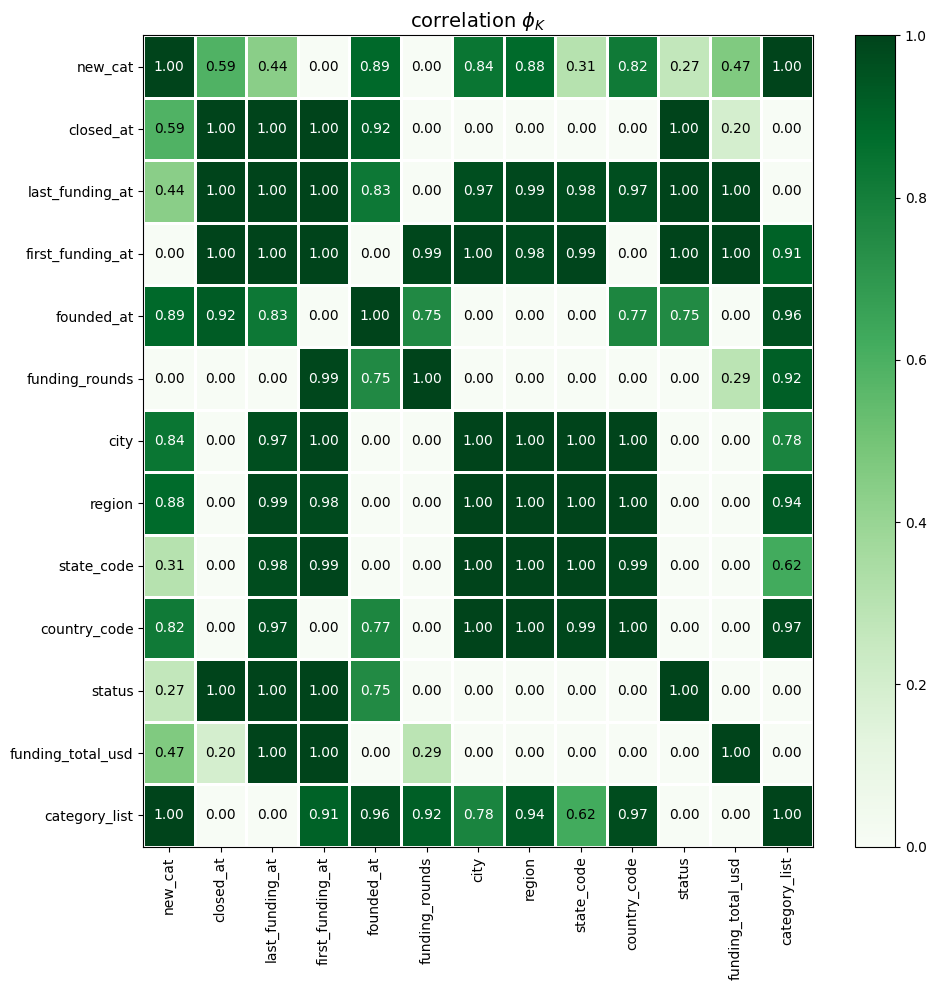

In [34]:
phik_overview = df.sample(100).phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Greens', 
                        title=r'correlation $\phi_K$', fontsize_factor=1, figsize=(10,10))
plt.tight_layout()

Заметно что датафрейм содержит много корреляционных признаков. Исправим это в дальнейшем.

In [35]:
df.shape

(51628, 13)

<a id='report_prepare'></a>
# Предварительный итог

На данном этапе были обработаны все пропуски в 9 признаках. Также были выявлены и удалены явные дубликаты. Обработанный датафрейм содержит 51627 записей. Корреляционная матрица phik показала сильную корреляцию между признаками, поэтому от части из них придется избавиться, а к части применить преобразования.

<a id='research'></a>
# Исследовательский анализ

На данном этапе посмотрим на графическое представление данных. Для этого сначала создадим дополнительные признаки для анализа.

In [36]:
df['founded_at'] = df['founded_at'].astype('datetime64[ns]')
df['closed_at'] = df['closed_at'].astype('datetime64[ns]')

Создадим признак `lifetime`, показывающий продолжительность жизни стартапа. Признак `growth_score`, показывающий насколько быстро растет стартап. И признак `funding_per_round`, показывающий сколько, в среднем, за один инвестиционный раунд было привлечено средств.

In [37]:
df.loc[:,'lifetime'] = (df.closed_at-df.founded_at).dt.days

In [38]:
df.loc[:,'growth_score'] = (df['funding_total_usd'] * df['funding_rounds']) /df['lifetime']

In [39]:
df.loc[:,'funding_per_round'] = df['funding_total_usd'] / df['funding_rounds']

In [40]:
def show_hist_box(col):
    """
    Функция которая принимает на вход признак (col) 
    и строит по нему histplot и boxplot
    """
    fig, axes = plt.subplots(nrows=2,
                           ncols=1,
                           gridspec_kw = {'height_ratios': (.3, .7)})
    sns.histplot(data = df[col], ax = axes[1], bins=10)
    sns.boxplot(x = df[col], ax = axes[0])
    axes[1].set_title('Распределение признака ' + col, fontsize = 12)
    axes[0].set_title('Диаграмма размаха признака ' + col, fontsize = 12)
    axes[1].axvline(df[col].mean(), c="r", label='Среднее')
    axes[1].axvline(df[col].median(), c="r", ls="--", label='Медиана')
    axes[1].set_ylabel('Частота')
    plt.legend()
    plt.tight_layout()
    plt.show()

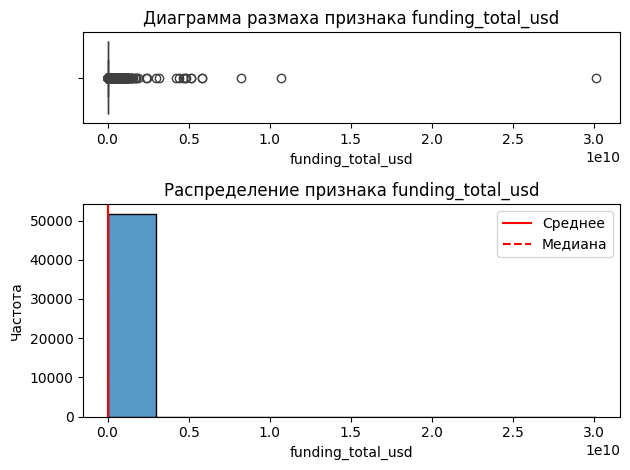

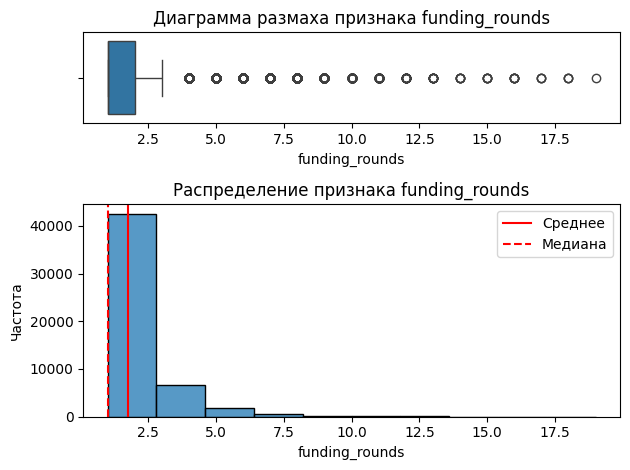

In [41]:
for i in interval_cols:
    show_hist_box(i)

Все числовые признаки содержат очень большой разброс данных. Особенно выделяется сильный выброс в признаке `funding_total_usd`, который может сильно исказить данные, посмотрим что это за строчка.

In [42]:
df.query('funding_total_usd == funding_total_usd.max()')

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat,lifetime,growth_score,funding_per_round
39186,Communications Infrastructure|Information Tech...,3.007950e+10,operating,USA,NY,New York City,New York,5,1983-10-07,2010-01-26,2014-02-28,2018-01-01,Mobile,12505,1.202699e+07,6.015901e+09


Стартап действильно существует очень долго, но за это время было проведено всего 5 инвестиционных раундов и скорее всего сумма является ошибочной, удалим эту строчку и посмотрим как изменился график.

In [43]:
df = df.query('funding_total_usd != funding_total_usd.max()')

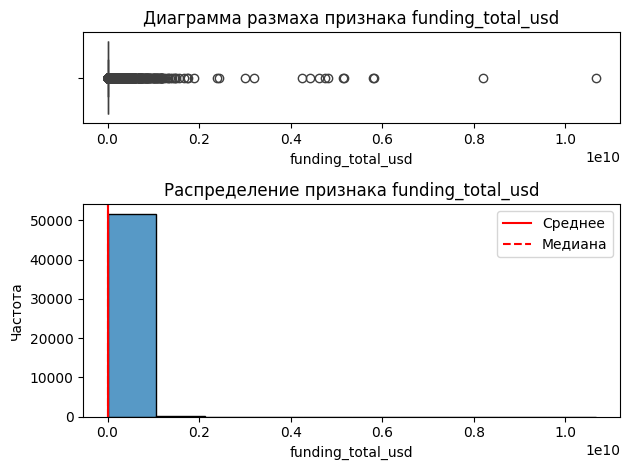

In [44]:
show_hist_box('funding_total_usd')

Добавим еще признаки которые помогут получше взглять на данные. Признак `found_year`, показывающий год основания стартапа, признак `found_month` - месяц основания стартапа и `len_cat` - число категорий с которыми работает стартап. 

In [45]:
df.loc[:,'found_year'] = df['founded_at'].dt.year

In [46]:
df.loc[:,'found_month'] = df['founded_at'].dt.month

In [47]:
df['len_cat'] = df['category_list'].str.split("|").apply(len)

In [48]:
def show_piegraph(col):
    """
    Функиця принимает на вход признак и строит пай-чарт
    с количеством значений входящих в этот признак
    """
    count = df[col].value_counts()
    plt.pie(count.iloc[0:10], 
            labels = count.iloc[0:10].index, 
            autopct = '%1.1f%%', 
            shadow=True)
    plt.title('Распределение значений среди признака - ' + col)
    plt.ylabel('')
    plt.rcParams['font.size'] = '8'
    plt.show()

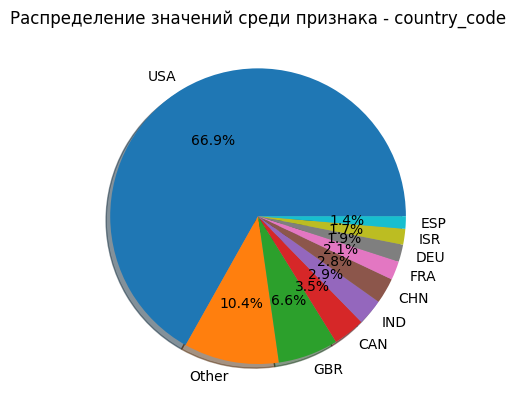

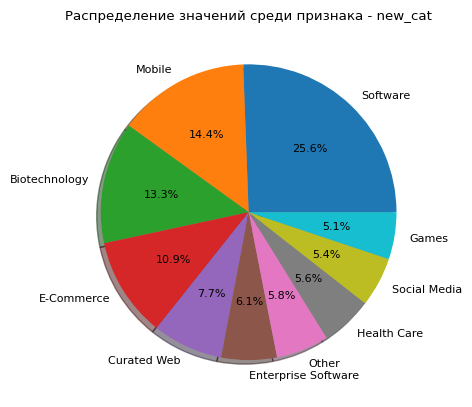

In [49]:
for i in ['country_code', 'new_cat']:
    show_piegraph(i)

Подавляющее большинство стартапов (почти 70%) представлено в USA, а категории распределены более плотно. Самая популярная категория "software (25%)", затем "mobile (14%)" и "biotechnology (13%)".

In [50]:
def show_count_with_hue(col):
    top20 = df[col].value_counts().head(20).index
    fig, axes = plt.subplots(nrows=2,
                           ncols=1,figsize=(12,8))
    ax1 = sns.countplot(data=df[df[col].isin(top20)], 
                        x=col, 
                        order=top20, 
                        edgecolor=sns.color_palette("dark"),
                        ax = axes[0]) 
    ax1.set_title('Распределение значений по признаку ' + col, fontsize=10)
    ax1.bar_label(ax1.containers[0])
    ax1.tick_params(axis='x', rotation=45)

    ax2 = sns.countplot(x=col, hue='status', 
                        palette="pastel", data=df[df[col].isin(top20)], 
                        order=top20, ax=axes[1])
    ax2.set_title('Распределение значений по признаку ' + col + ' с разбивкой по status', 
                  fontsize=10)
    ax2.set_ylabel('Частота')
    ax2.legend(loc="upper right", fontsize=8, labels=['closed', 'acquired'])
    ax2.tick_params(axis='x', rotation=45)
    
    # Добавление общего количества над столбцами для второго графика
    for container in ax2.containers:
        ax2.bar_label(container)
    
    plt.tight_layout()
    plt.show()

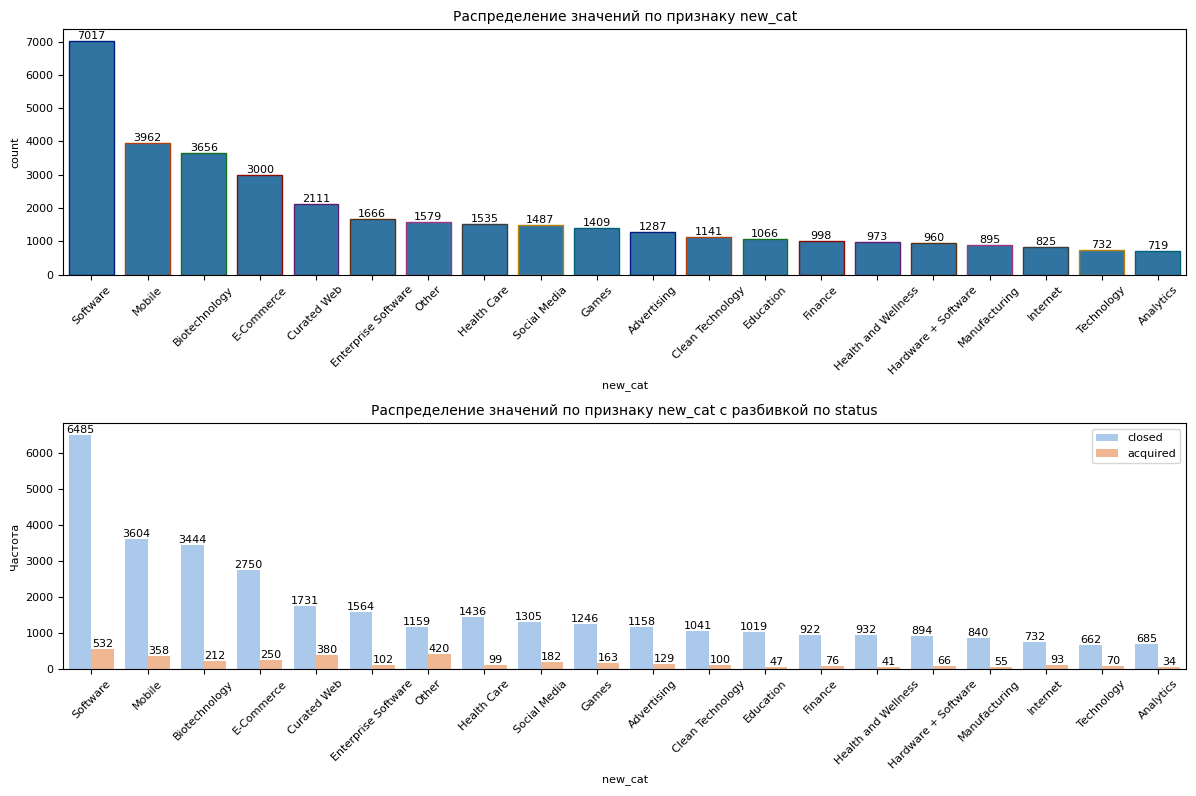

In [51]:
show_count_with_hue('new_cat')

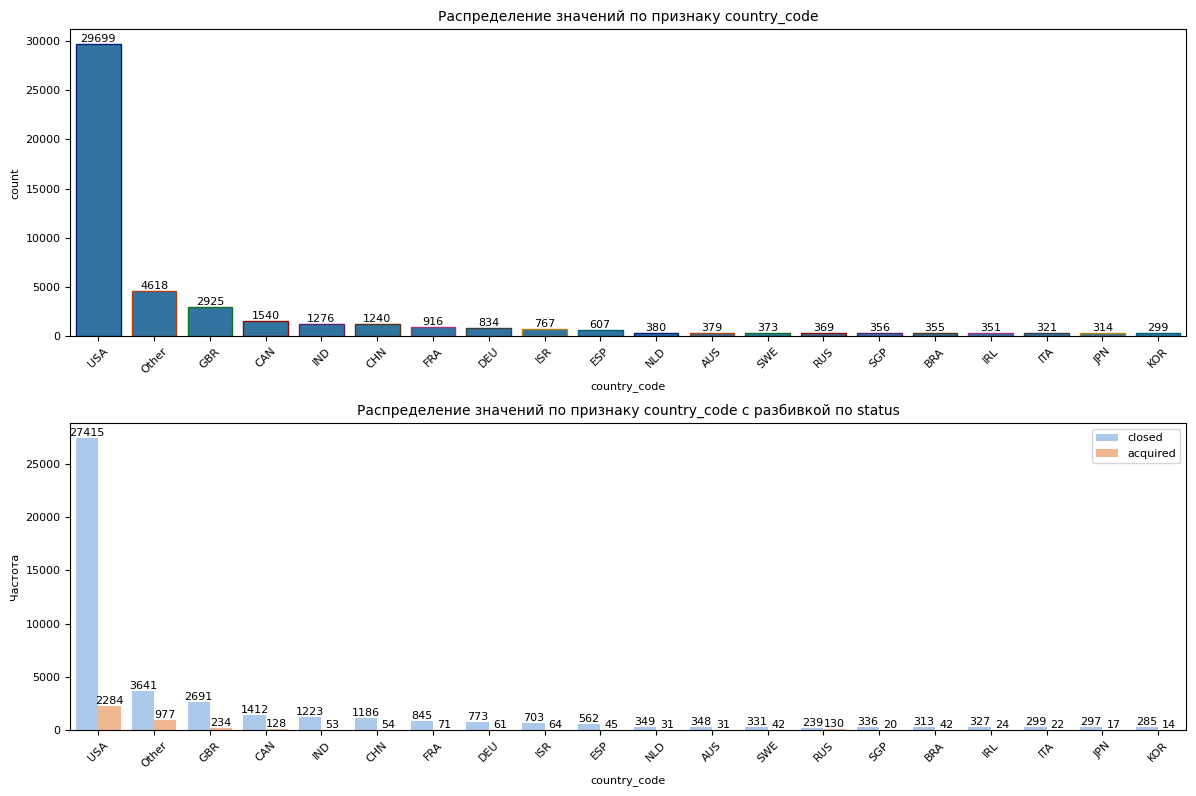

In [52]:
show_count_with_hue('country_code')

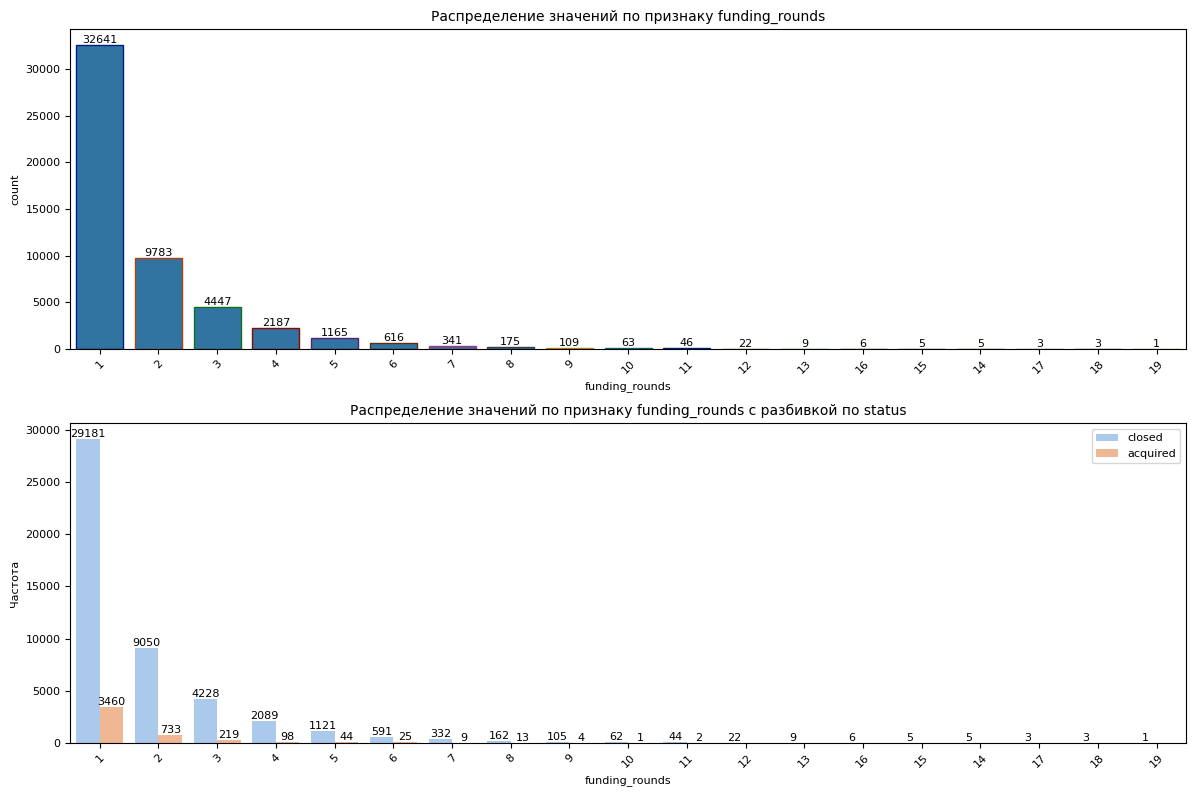

In [53]:
show_count_with_hue('funding_rounds')

Больше всего стартапов создано в категории *softwate*, там же наблюдается и самое большое количество закрытых стартапов, но в % соотношении оно самое минимальное, за счет количества открытых. Худшая ситуация по количеству открытых/закрытых наблюдается в категории *Other*.
В графике по странам, в *Other* так же худшая ситуация, а с положительной точки зрения *USA* лидирует с большим отрывом (27415 открытых стартапов).
Большинство стартапов провели 1 инвестиционный раунд, но стоит обратить внимание на стартап который провел 19 раундов. 

In [54]:
df.query('funding_rounds == 19')

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat,lifetime,growth_score,funding_per_round,found_year,found_month,len_cat
52329,Enterprise Software,242948825.0,operating,USA,CA,Anaheim,Irvine,19,2005-01-01,2005-02-28,2015-01-05,2018-01-01,Enterprise Software,4748,972204.649326,1.278678e+07,2005,1,1


Text(0, 0.5, 'Число раундов')

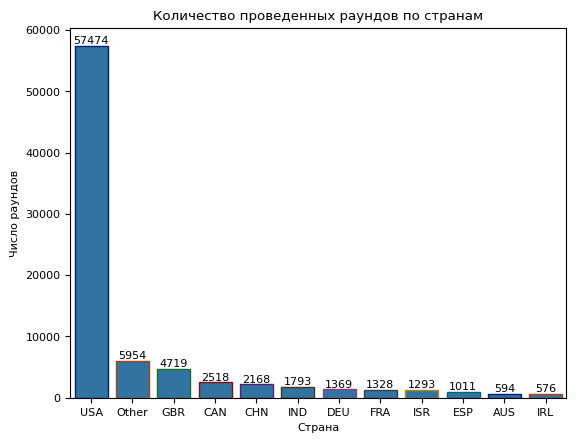

In [55]:
df_funding=(df.groupby(["country_code"])["funding_rounds"].sum()
            .sort_values(ascending=False).reset_index().head(12))
ax = sns.barplot(x=df_funding["country_code"], y=df_funding["funding_rounds"], 
                 edgecolor=sns.color_palette("dark"))
for container in ax.containers :
    ax.bar_label (container)
plt.title('Количество проведенных раундов по странам')
plt.xlabel('Страна')
plt.ylabel('Число раундов')

С точки зрения количества проведенных инвестиционных раундов, тут логично что *USA* также на первом месте по общему количеству проведенных финансовых раундов. 

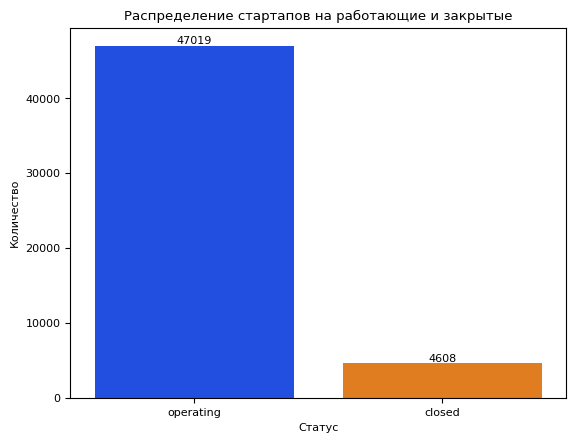

In [56]:
ax = sns.countplot(x = df['status'], palette = 'bright')
for container in ax.containers :
    ax.bar_label(container)
plt.title('Распределение стартапов на работающие и закрытые')
plt.xlabel('Статус')
plt.ylabel('Количество')
plt.show()

В распределении целевого признака `status` отметим сильный дисбаланс классов, стоит это учесть при прогнозировании.

In [57]:
def show_fund(col):
    ###   Total startups financing by industries
    funding_sorted = pd.pivot_table(df,
                  index=col,
                  values=['funding_total_usd'],
                  aggfunc=['sum']
                  ).reset_index()
    funding_sorted = funding_sorted.sort_values(by=('sum', 'funding_total_usd'), 
                                                ascending=False)
    top20 = funding_sorted.head(20)
    
    top20.columns = [col, 'funding_total_usd']
    top20 = top20.sort_values(['funding_total_usd'], ascending = False)
    fig, ax = plt.subplots(figsize=(20,7))
    funding_rate = sns.barplot(x=col, y="funding_total_usd", data=top20, 
                               ax=ax, edgecolor=sns.color_palette("dark"))
    funding_rate = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    funding_rate = ax.set(xlabel=col.title(), ylabel="Собрано средств, млрд USD")
    for container in ax.containers :
        ax.bar_label(container, fmt=lambda x: '{:.2f} млрд USD'.format(x / 1000000000), 
                     label_type='edge', fontsize=6)    

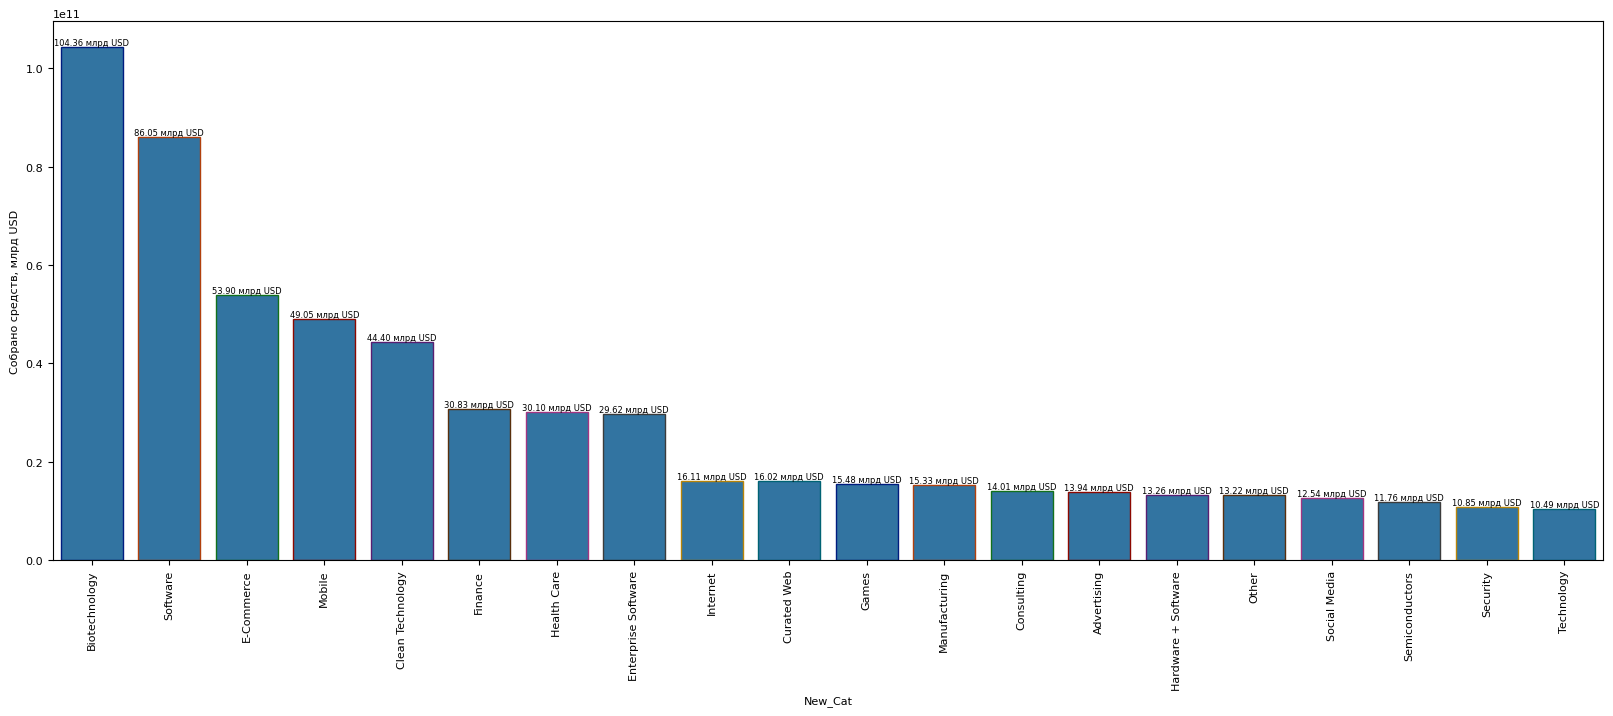

In [58]:
show_fund('new_cat')

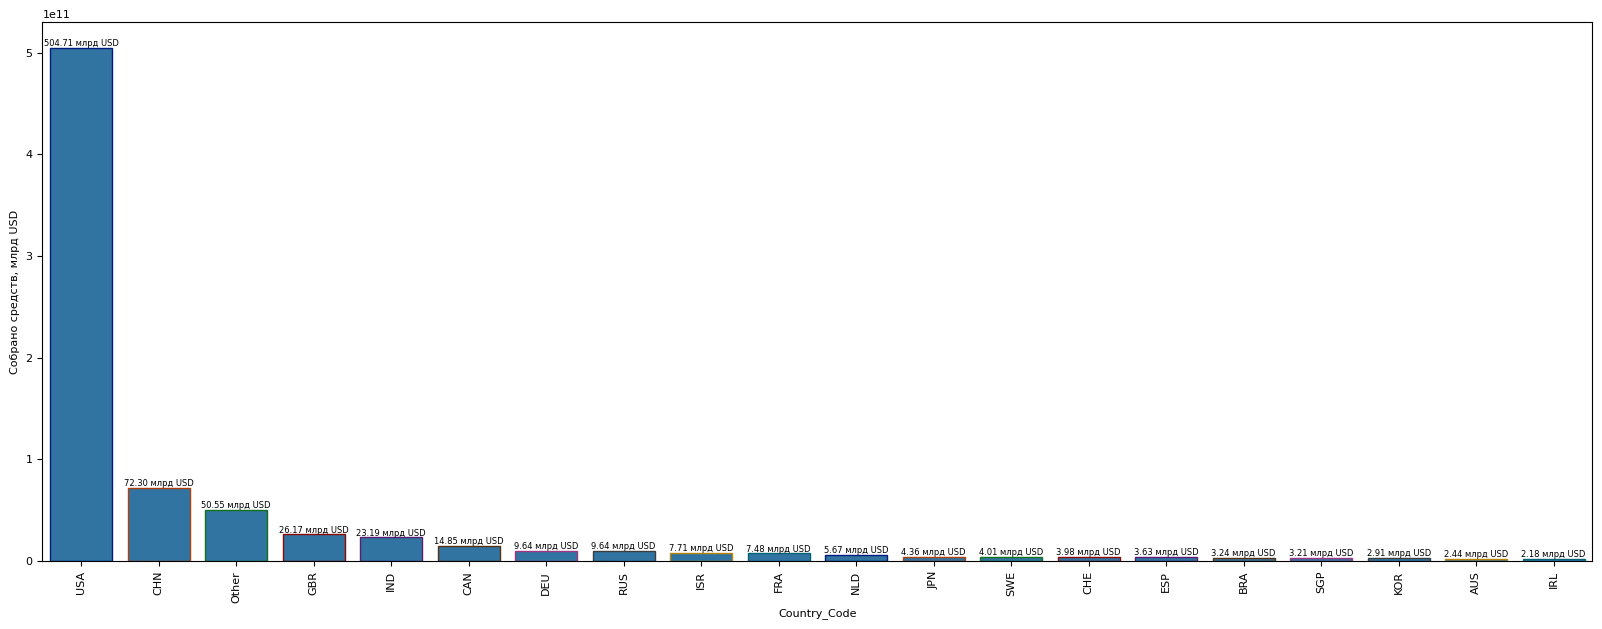

In [59]:
show_fund('country_code')

Стоит отметить, что несмотря на то что большинство стартапов создаются в категории *software*, наибольшее количество средств привлекли стартапы из категории *biotechnology*. Если мы посмотрим по странам, то *USA* охраняют первое место, а на второе вышла *CHN*.

In [60]:
def show_ratio(col):
    calc_ratio = df.groupby(col).agg(
        open_count=pd.NamedAgg(column='status', aggfunc=lambda x: (x == 'operating').sum()),
        total_count=pd.NamedAgg(column='status', aggfunc='count')
    )
    calc_ratio['open_ratio'] = calc_ratio['open_count'] / calc_ratio['total_count'] * 100
    calc_ratio = calc_ratio.reset_index().sort_values('total_count', ascending=False).head(5)
    display(calc_ratio)

    plt.figure(figsize=(10, 6))
    ax1 = sns.barplot(x=col, y='open_ratio', data=calc_ratio.sort_values('open_ratio', 
                                                                         ascending=False))
    plt.xticks(rotation=90)
    plt.xlabel(col)
    plt.ylabel('Соотношение открытых стартапов')
    plt.title('Соотношение открытых стартапов к общему числу стартапов по ' + col)
    
    container = ax1.containers[0]
    ax1.bar_label(container, fmt='%.1f%%')
    
    ax2 = ax1.twinx()
    ax2.plot(calc_ratio.sort_values('open_ratio', ascending=False)[col], 
             calc_ratio.sort_values('open_ratio', ascending=False)['total_count'], color='r')
    ax2.set_ylabel('Общее число стартапов', color='r')
    
    plt.tight_layout()
    for i, total in enumerate(calc_ratio.sort_values('open_ratio', ascending=False)['total_count']):
        ax2.text(i, total, str(total), color='r', ha='center', fontsize=10)
    # Отображаем график
    plt.show()


,country_code,open_count,total_count,open_ratio
128,USA,27415,29699,92.309505
94,Other,3641,4618,78.843655
39,GBR,2691,2925,92.000000
19,CAN,1412,1540,91.688312
52,IND,1223,1276,95.846395


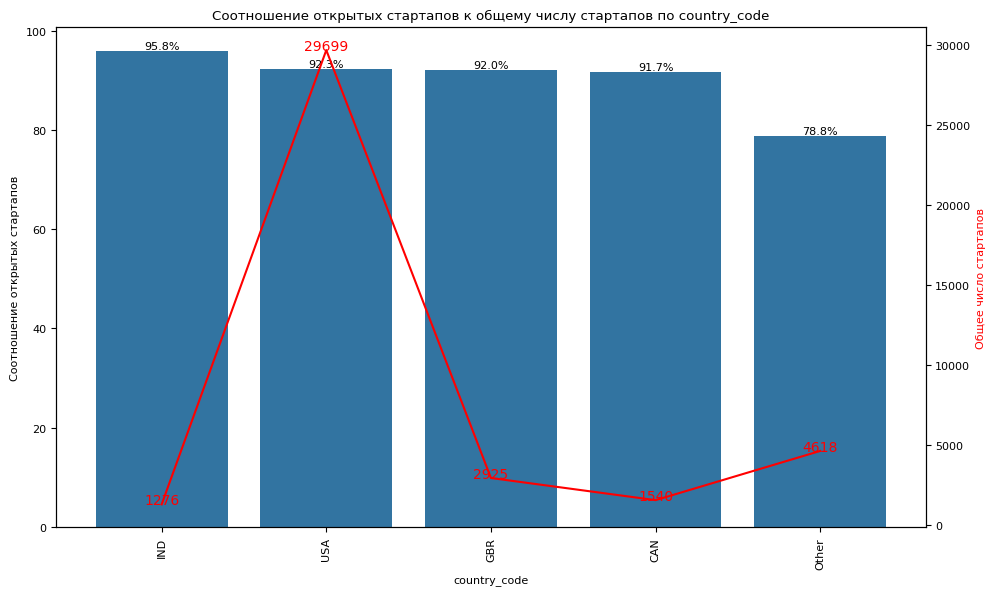

In [61]:
show_ratio('country_code')

,new_cat,open_count,total_count,open_ratio
448,Software,6485,7017,92.418412
302,Mobile,3604,3962,90.964160
49,Biotechnology,3444,3656,94.201313
144,E-Commerce,2750,3000,91.666667
116,Curated Web,1731,2111,81.999053


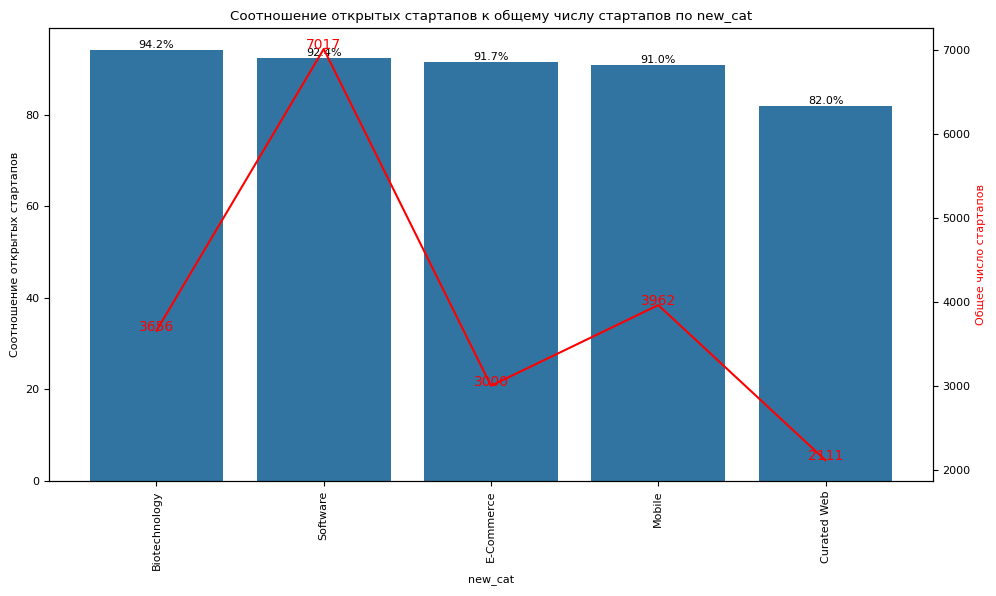

In [62]:
show_ratio('new_cat')

Наилучший % по соотношению открытых/закрытых стартапов, лидирует *IND* с показателем 95.8%. *USA* лидируя по количественному признаку, в % соотношении на 2 месте с показателем 92.3%.
Лучший показатель в % соотношении среди категорий находится у *biotechnology* с результатом 92.4%.

In [63]:
def show_scatter(col1, col2, col3, col4, col5, col6):
    """
    Функция принимает признаки и строит scatterplot
    """
    fig, axes = plt.subplots(nrows=3,
                               ncols=2,figsize=(10,8))
    ax1 = sns.scatterplot(x=df[col2], y=df[col1], ax = axes[0, 0], hue=df['status'])
    ax1.set_title('Взаимосвязь между ' + col1 + ' и ' + col2)
    ax2 = sns.scatterplot(x=df[col3], y=df[col2], ax = axes[0, 1], hue=df['status'])
    ax2.set_title('Взаимосвязь между ' + col3 + ' и ' + col2)
    ax3 = sns.scatterplot(x=df[col2], y=df[col4], ax = axes[1, 0], hue=df['status'])
    ax3.set_title('Взаимосвязь между ' + col4 + ' и ' + col2)
    ax4 = sns.scatterplot(x=df[col3], y=df[col5], ax = axes[1, 1], hue=df['status'])
    ax4.set_title('Взаимосвязь между ' + col3 + ' и ' + col5)
    ax5 = sns.scatterplot(x=df[col2], y=df[col6], ax = axes[2, 0], hue=df['status'])
    ax5.set_title('Взаимосвязь между ' + col6 + ' и ' + col2)
    ax6 = sns.scatterplot(x=df[col3], y=df[col6], ax = axes[2, 1], hue=df['status'])
    ax6.set_title('Взаимосвязь между ' + col6 + ' и ' + col3)
    plt.tight_layout()

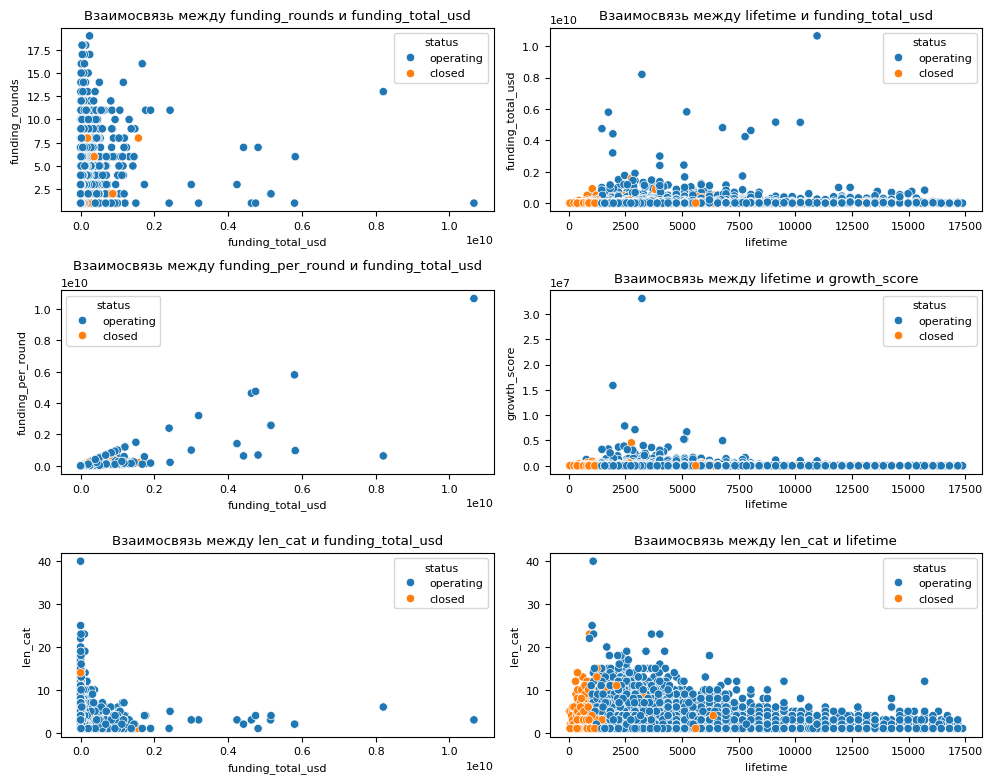

In [64]:
show_scatter('funding_rounds', 'funding_total_usd', 'lifetime', 
             'funding_per_round', 'growth_score', 'len_cat')

В диаграммах рассеяния в каждом графике наблюдаются точечные выбросы, наибольшая корреляция наблюдается между признаками `funding_total_usd` и `funding_per_round`, что логично, так как чем больше инвестиционных раундов проводит стартап, тем больше денег это может привести. Также стоит отметить что в основном закрытие происходит в первые 4-5 лет стартапа.

In [65]:
def show_trend(data, title):
    """
    Функция которая принимает датафрейм (data), группирует по признаку country_code и new_cat,
    находит наиболее часто встречающююся категорию и выводит ее для каждой страны
    """
    group_trend = (data.groupby(['country_code', 'new_cat'])
                   .size().rename('num_startup').reset_index())   
    # Выборка наиболее трендовых категорий для каждого города
    group_trend = (group_trend[group_trend.groupby('country_code')['num_startup']
                   .transform(max) == group_trend['num_startup']].reset_index(drop=True))   
    # Сортировка результатов по убыванию количества стартапов
    group_trend = group_trend.sort_values('num_startup', ascending=False).head(15)   
    # Вывод отсортированного DataFrame
    display(group_trend.head(5))

    plt.figure(figsize=(12, 5))
    ax = plt.bar(group_trend['country_code'], group_trend['num_startup'])
    
    # Добавляем названия для осей и заголовок
    plt.xlabel('Категория стартапов')
    plt.ylabel('Количество стартапов')
    plt.title('Наиболее популярные категории ' + title + ' стартапов по странам')
    
    # Добавляем значения над столбцами
    for bar, category, num in zip(ax, group_trend['new_cat'], group_trend['num_startup']):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{category}, {num}', 
                 ha='center', va='bottom', fontsize = 6)
    # Поворачиваем метки на оси X для лучшей читаемости
    plt.xticks(rotation=45, ha='right')
    # Отображаем график
    plt.tight_layout()
    plt.show()

,country_code,new_cat,num_startup
191,USA,Software,4377
140,Other,Software,438
54,GBR,Software,366
30,CAN,Software,250
53,FRA,Software,162


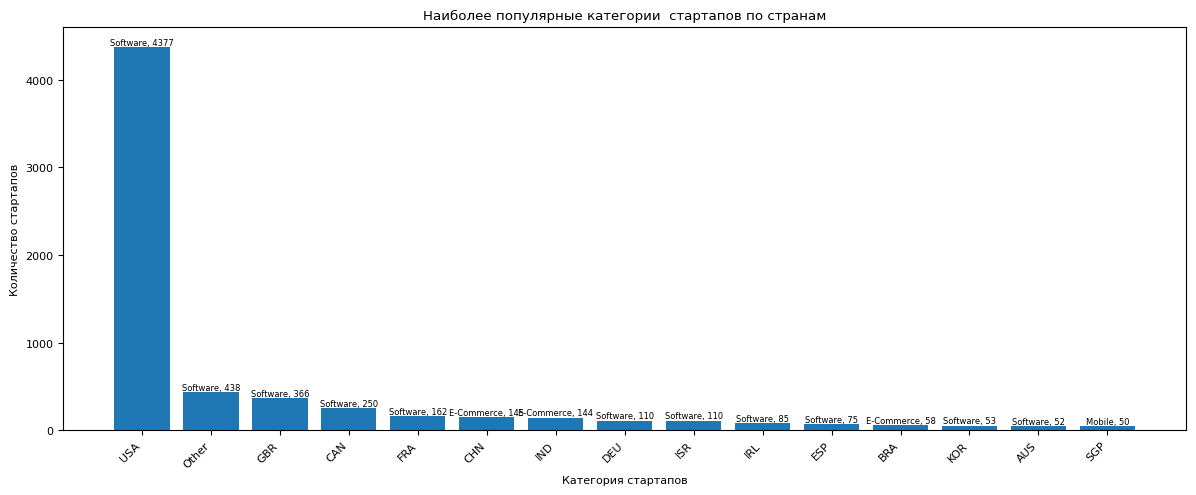

In [66]:
show_trend(df, '')

In [67]:
df_closed = df[(df["status"] == 'closed')]
df_closed.shape

(4608, 19)

,country_code,new_cat,num_startup
116,USA,Software,276
73,Other,Other,182
35,GBR,Software,35
15,CAN,Software,21
94,RUS,Software,15


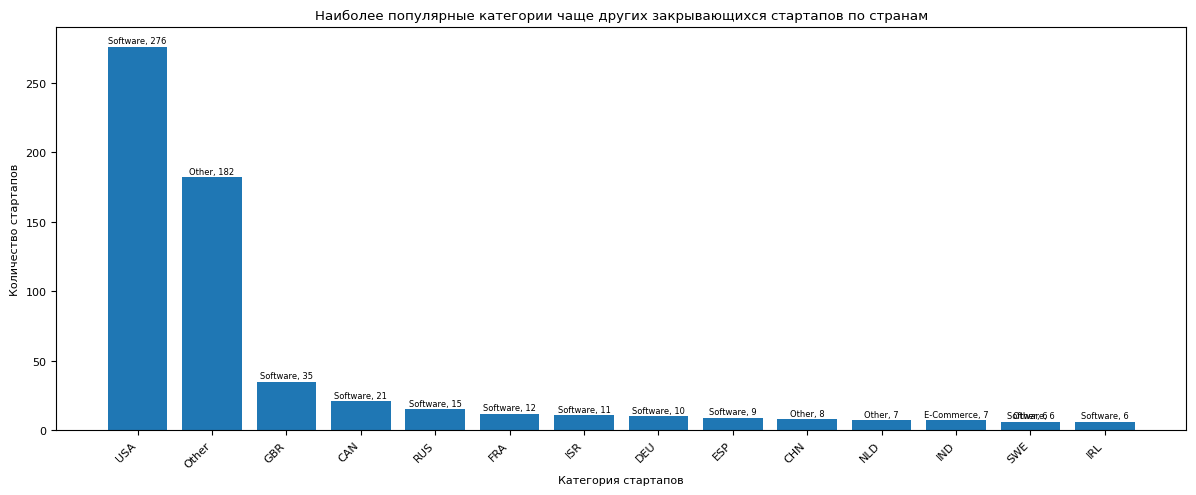

In [68]:
show_trend(df_closed, 'чаще других закрывающихся')

In [69]:
df_open = df[(df["status"] == 'operating')]
df_open.shape

(47019, 19)

,country_code,new_cat,num_startup
190,USA,Software,4101
143,Other,Software,369
60,GBR,Software,331
28,CAN,Software,229
59,FRA,Software,150


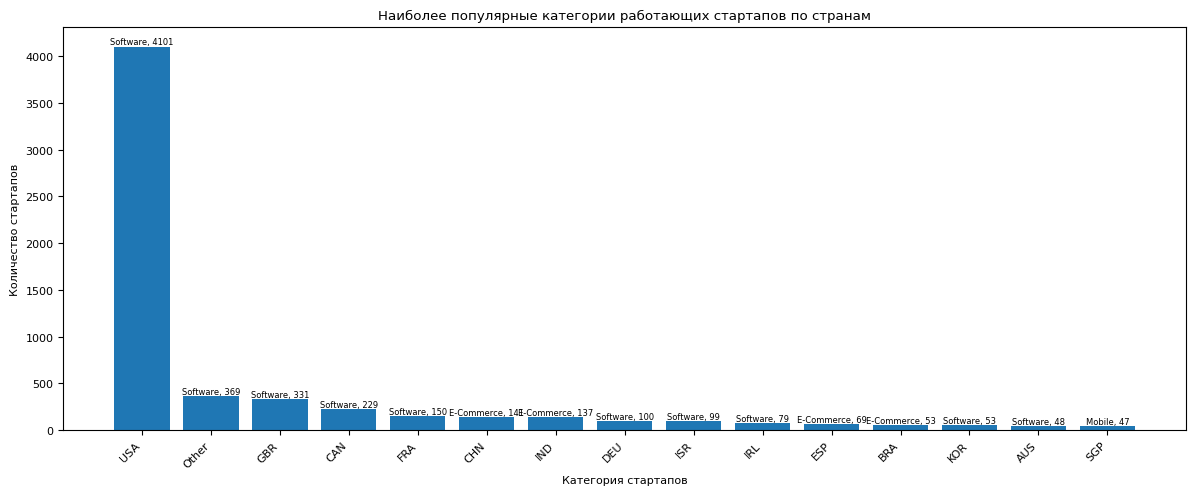

In [70]:
show_trend(df_open, 'работающих')

Рассматривая график трендов, отметим что категория `software` наиболее популярна в 11 из 15 стран по общему количеству.
Также категория `software` представлена в 10 случаях из 15 странах какая самая частая среди закрытых. 

In [71]:
def show_bar_with_norm(col):
    """
    Функция принимает признак col и строит распределение данных по нему"""
    normalized_values = df[col].value_counts(normalize=True).sort_values(ascending=False)
    top15_normalized = normalized_values.head(15)
    top15_index = top15_normalized.index
    
    ax = sns.countplot(data=df[df[col].isin(top15_index)], x=col, order=top15_index, 
                       edgecolor=sns.color_palette("dark"))
    
    ax.bar_label(ax.containers[0])
    plt.title('Распределение значений по признаку ' + col + ' (top15)')
    ax.set(xlabel=col.title(), ylabel="Number of startups")
    
    for i, val in enumerate(top15_index):
        frequency = top15_normalized[val]
        ax.text(i, ax.patches[i].get_height()/2, f'{frequency:.2%}', 
                color='black', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

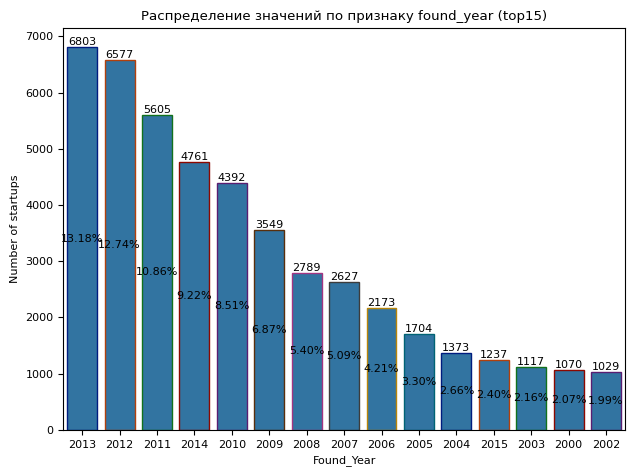

In [72]:
show_bar_with_norm('found_year')

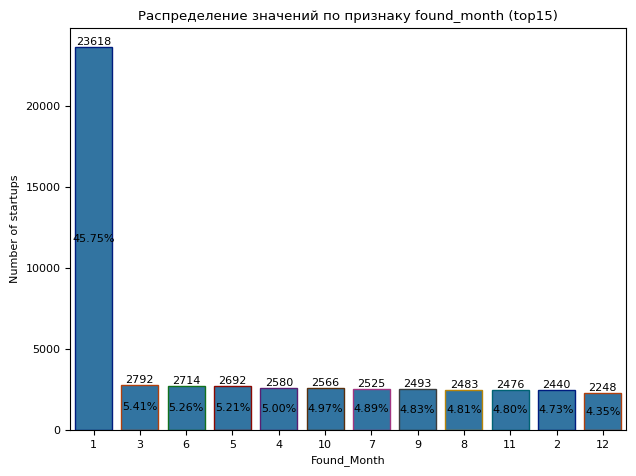

In [73]:
show_bar_with_norm('found_month')

Количество стартапов росло с каждым годом начиная с 2002 года, пик основания стартапов пришелся на 2013 год, после этого наблюдается спад. Количество стартапов в 2014 году меньше уже почти на 2042 по сравнению с 2013 годом, а в 2015 уже на 5566 меньше чем в 2013 году. Данные по 2016-2017 годам в распределение вообще не попали из-за малого количества. 
Распределение по месяцам выглядит еще интереснее, 46% стартапов создаются в 1 месяц года. Возможно это связано с налоговыми вопросами.

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51627 entries, 0 to 52515
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   category_list      51627 non-null  object        
 1   funding_total_usd  51627 non-null  float64       
 2   status             51627 non-null  object        
 3   country_code       51627 non-null  object        
 4   state_code         51627 non-null  object        
 5   region             51627 non-null  object        
 6   city               51627 non-null  object        
 7   funding_rounds     51627 non-null  int64         
 8   founded_at         51627 non-null  datetime64[ns]
 9   first_funding_at   51627 non-null  object        
 10  last_funding_at    51627 non-null  object        
 11  closed_at          51627 non-null  datetime64[ns]
 12  new_cat            51627 non-null  object        
 13  lifetime           51627 non-null  int64         
 14  growth_scor

Удалим дополнительные признаки которые добавили для исследовательского анализа.

In [75]:
df = df.drop(['found_year', 'found_month', 'len_cat'], axis=1)

<a id='report_research'></a>
# Предварительный вывод

На данном этапе были созданы дополнительные признаки `lifetime`, показывающий продолжительность жизни стартапа, признак `growth_score`, показывающий насколько быстро растет стартап, признак `funding_per_round`, показывающий сколько, в среднем, за один инвестиционный раунд было привлечено средств, признак `found_year`, показывающий год основания стартапа, признак `found_month` - месяц основания стартапа и `len_cat` - число категорий с которыми работает стартап. 

Диаграмма размаха показала что все числовые признаки содержат очень большой разброс данных. Особенно выделялся один выброс в признаке funding_total_usd, который мы удалили для более точного обучения модели.
Подавляющее большинство стартапов (почти 70%) представлено в USA, а самая популярная категория идет "software (25%)", затем "mobile (14%)" и "biotechnology (13%)".

Больше всего стартапов создано в категории *softwate*, там же наблюдается и самое большое количество закрытых стартапов, но в % соотношении оно самое минимальное, за счет количества открытых. Худшая ситуация по количеству открытых/закрытых наблюдается в категории *Other*.
В графике по странам, в *Other* так же худшая ситуация, а с положительной точки зрения *USA* лидирует с большим отрывом (27415 открытых стартапов).
Большинство стартапов провели 1 инвестиционный раунд, однако есть и стартапы которые провели более 15 раундов. Больше всех инвестиционных раундов провела *USA* - 57 474 раундов.

Целевой признак `status` имеет сильный дисбаланс - 47019 открытых против 4608 закрытых.

Несмотря на то что большинство стартапов создаются в категории *software*, больше всех денег принесла категория *biotechnology*. По странам больше всех денег принесли стартапы из *USA* - 504 млрд долларов. 

По соотношению % по соотношению открытых/закрытых стартапов, лидирует *IND* с показателем 95.8%. *USA* лидируя по количественному признаку, в % соотношении на 2 месте с показателем 92.3%.
Лучший показатель в % соотношении среди категорий находится у *biotechnology* с результатом 92.4%.

Диаграммы рассеяния показала точечные выбросы на каждом графике, наибольшая корреляция наблюдается между признаками `funding_total_usd` и `funding_per_round`, что логично, так как чем больше инвестиционных раундов проводит стартап, тем больше денег это может привести. Также стоит отметить что в основном закрытие происходит в первые 4-5 лет стартапа.

Категория *software* наиболее популярная в 11 странах из топ15.

Количество стартапов росло с каждым годом начиная с 2002 года, пик основания стартапов пришелся на 2013 год, после этого наблюдается спад. Количество стартапов в 2014 году меньше уже почти на 2042 по сравнению с 2013 годом, а в 2015 уже на 5566 меньше чем в 2013 году. Данные по 2016-2017 годам в распределение вообще не попали из-за малого количества. 
Распределение по месяцам выглядит еще интереснее, 46% стартапов создаются в 1 месяц года.

<a id='feat'></a>
# Работа с признаками

На предыдущих этапах было выявлено много коррелирующих между собой признаков, исправим это на данном этапе.

In [76]:
interval_cols = df.select_dtypes('number').columns.tolist()

In [77]:
def plot_for_log():
    """
    Функция которая показывают диаграмму размаха для количественных признаков
    """
    plt.figure(figsize=(12, 4))
    for i in range(0, len(interval_cols)):
        plt.subplot(1, len(interval_cols), i+1)
        sns.boxplot(y=df[interval_cols[i]], color='green', orient='v')
        plt.tight_layout()
    plt.suptitle('Диаграмма размаха для количественных признаков', fontsize=12, y=1.03)
    plt.show()

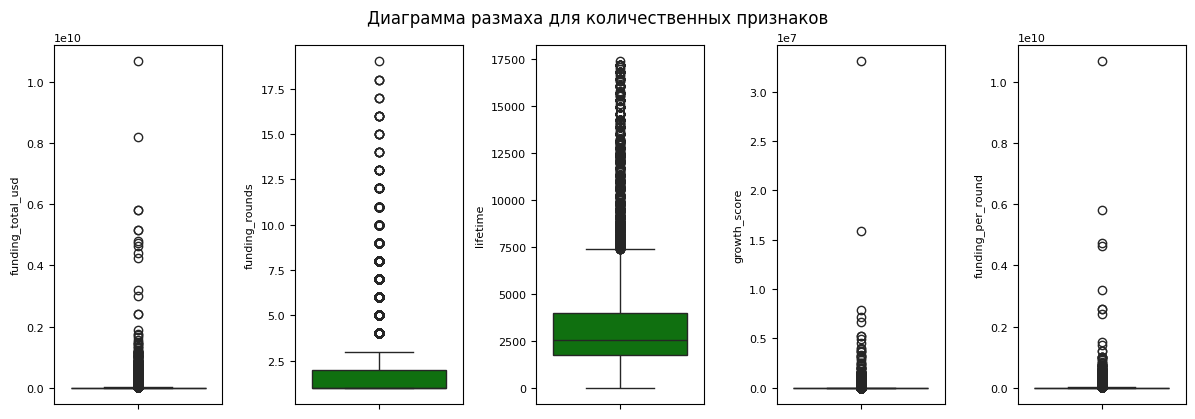

In [78]:
plot_for_log()

Все количественные признаки содержат большое количество выбросов, применим к ним логарифмическое преобразование.

In [79]:
df["funding_total_usd"] = np.log1p(df["funding_total_usd"])

In [80]:
df['funding_per_round'] = np.log1p(df["funding_per_round"])

In [81]:
df['growth_score'] = np.log1p(df["growth_score"])

In [82]:
df["funding_rounds"] = np.log1p(df["funding_rounds"])

In [83]:
df["lifetime"] = np.log1p(df["lifetime"])

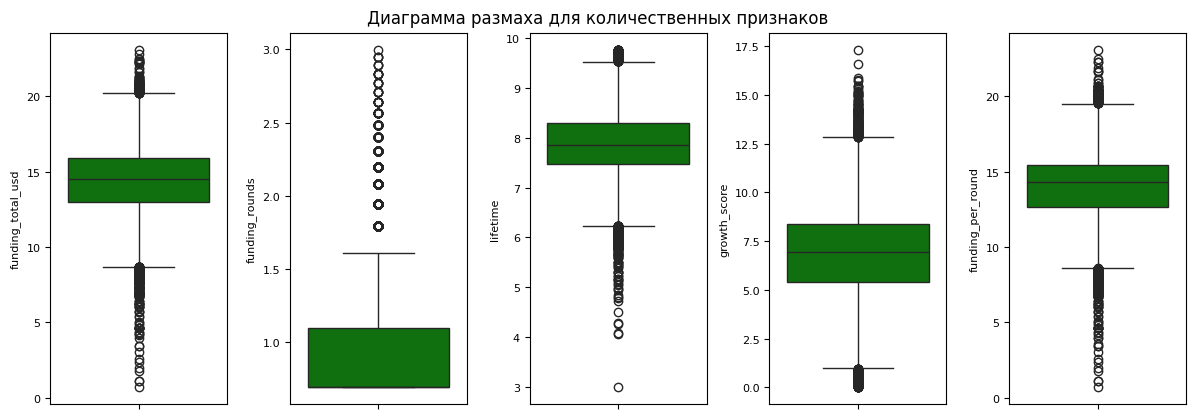

In [84]:
plot_for_log()

Применим полиномиальное преобразование для признаков `lifetime`, `funding_rounds`. В качестве степени будем использовать 2 (квадратичные признаки). 

In [85]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

In [86]:
poly_columns = poly_features.fit_transform(df[['lifetime', 'funding_rounds']])

In [87]:
df_poly = pd.DataFrame(poly_columns, 
                       columns=['lifetime', 'funding_rounds', 'lifetime^2', 
                                'lifetime*funding_rounds', 'funding_rounds^2'],
                       index=df.index)

In [88]:
df_poly = df_poly.drop(['lifetime', 'funding_rounds'], axis=1)

In [89]:
df = pd.concat([df, df_poly], axis=1)

Добавим еще один признак `days_between`, показывающий сколько прошло времени между последним и первым инвестиционным раундом, и посмотрим на его распределение

In [90]:
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'])
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'])
df['days_between'] = (df['last_funding_at'] - df['first_funding_at']).dt.days

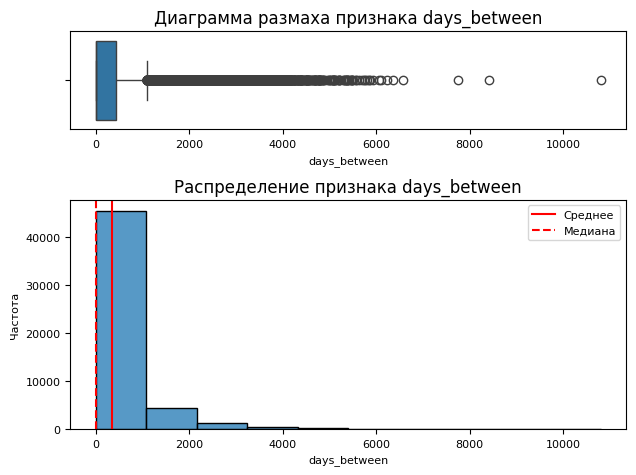

In [91]:
show_hist_box('days_between')

In [92]:
df["days_between"] = np.log1p(df["days_between"])

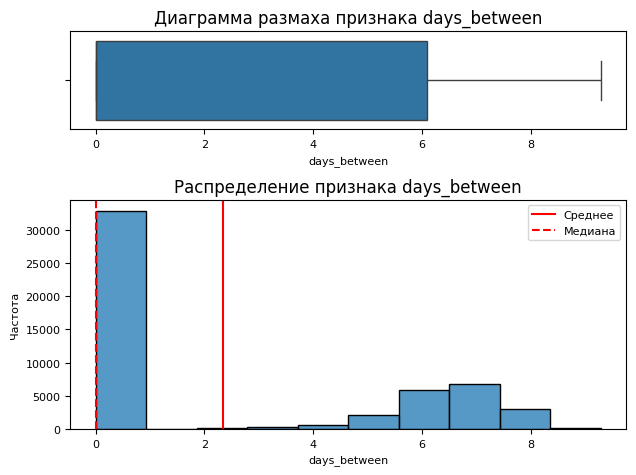

In [93]:
show_hist_box('days_between')

Посмотрим как выглядит итоговый датафрейм и удалим ненужные признаки.

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51627 entries, 0 to 52515
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   category_list            51627 non-null  object        
 1   funding_total_usd        51627 non-null  float64       
 2   status                   51627 non-null  object        
 3   country_code             51627 non-null  object        
 4   state_code               51627 non-null  object        
 5   region                   51627 non-null  object        
 6   city                     51627 non-null  object        
 7   funding_rounds           51627 non-null  float64       
 8   founded_at               51627 non-null  datetime64[ns]
 9   first_funding_at         51627 non-null  datetime64[ns]
 10  last_funding_at          51627 non-null  datetime64[ns]
 11  closed_at                51627 non-null  datetime64[ns]
 12  new_cat                  51627 non-nu

In [95]:
df.head()

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat,lifetime,growth_score,funding_per_round,lifetime^2,lifetime*funding_rounds,funding_rounds^2,days_between
0,Online Reservations|Restaurants,13.627525,operating,CHE,25,Zurich,Zürich,1.098612,2009-10-17,2011-05-01,2014-12-01,2018-01-01,Restaurants,8.006034,6.316778,12.934379,64.096583,8.795528,1.206949,7.178545
1,Manufacturing|Medical|Medical Devices,17.575198,operating,USA,CA,SF Bay Area,Redwood City,1.609438,2005-01-01,2010-05-04,2014-02-25,2018-01-01,Manufacturing,8.465689,10.496042,16.188904,71.667896,13.625001,2.590290,7.239933
2,Biotechnology,17.383814,operating,USA,CA,SF Bay Area,San Jose,1.386294,2006-01-01,2012-08-20,2014-07-02,2018-01-01,Biotechnology,8.385717,10.096979,16.285202,70.320247,11.625072,1.921812,6.525030
3,Health Care,16.917853,operating,Other,Other,Other,Other,1.386294,2004-01-01,2011-09-01,2014-07-18,2018-01-01,Health Care,8.539933,9.476804,15.819240,72.930450,11.838861,1.921812,6.958448
4,Manufacturing,10.082428,operating,USA,VA,VA - Other,Bristol,0.693147,2010-05-12,2012-02-01,2012-02-01,2018-01-01,Manufacturing,7.934513,2.258601,10.082428,62.956504,5.499786,0.480453,0.000000


In [96]:
df = df.drop(['category_list', 'state_code', 'region','city','founded_at',
              'first_funding_at', 'last_funding_at', 'closed_at', 
              'funding_rounds', 'funding_rounds^2'], axis=1)

Посмотрим как теперь выглядит корреляционная матрица

In [97]:
interval_cols = df.select_dtypes('number').columns.tolist()

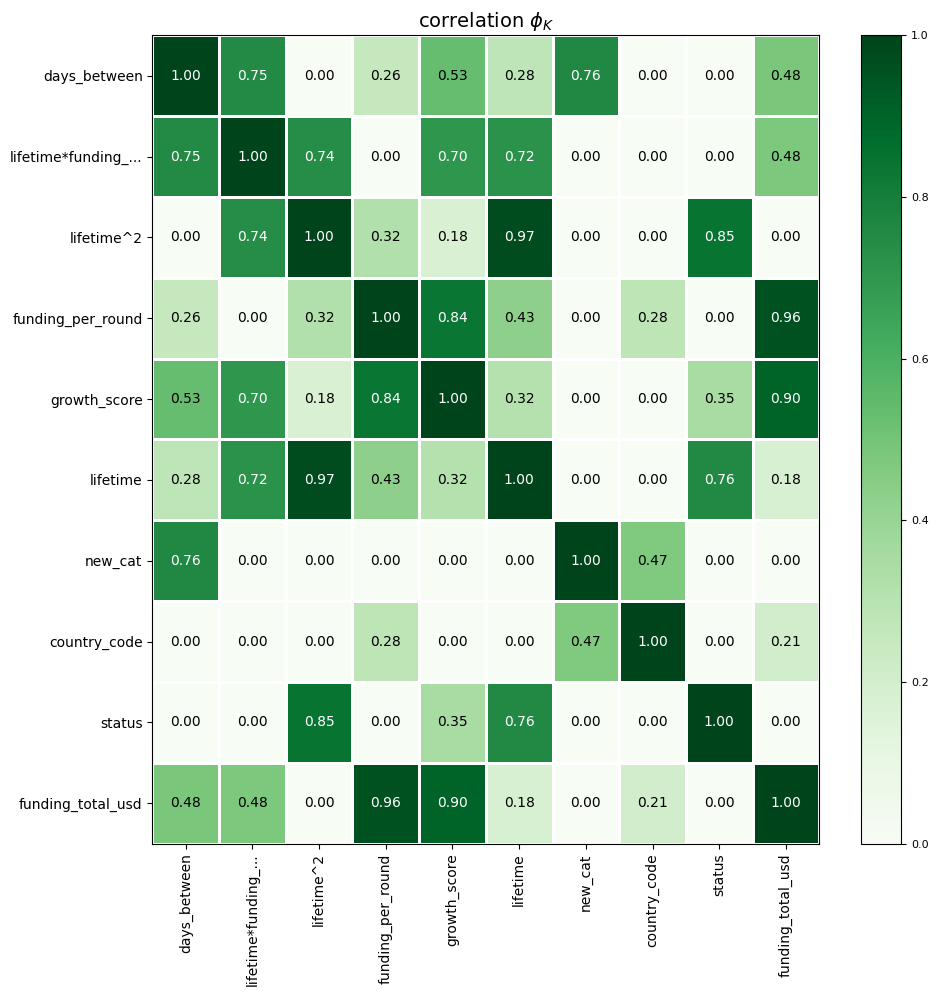

In [98]:
phik_overview = df.sample(100).phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Greens', 
                        title=r'correlation $\phi_K$', fontsize_factor=1, figsize=(10,10))
plt.tight_layout()

Ситуация стала лучше, но нужно еще поработать с признаками. Заменим значения признака `country_code` с категориальных на числовые, в зависимости от частоты появления в датафрейме.


In [99]:
frequency_encoding = df['country_code'].value_counts(normalize=True)

In [100]:
df['country_code'] = df['country_code'].map(frequency_encoding)

Признак `new_cat` содержит много уникальных категориальных значений, сгруппируем их в 20 категорий. Для этого преобразуем их в матрицу TF-IDF и обучим модель k-средних на этой матрице.

In [101]:
vectorizer = TfidfVectorizer(max_features=5000)

In [102]:
tfidf_matrix = vectorizer.fit_transform(df['new_cat'])

In [103]:
kmeans = KMeans(n_clusters=20, random_state=RANDOM_STATE)

In [104]:
kmeans.fit(tfidf_matrix)

KMeans(n_clusters=20, random_state=42)

In [105]:
labels = kmeans.labels_

In [106]:
clustered_df = pd.DataFrame({'new_cat': df['new_cat'], 'cluster': labels})

In [107]:
df['new_cat'] = clustered_df['cluster']

Посмотрим к чему привели эти преобразования

In [108]:
df.head()

,funding_total_usd,status,country_code,new_cat,lifetime,growth_score,funding_per_round,lifetime^2,lifetime*funding_rounds,days_between
0,13.627525,operating,0.005075,11,8.006034,6.316778,12.934379,64.096583,8.795528,7.178545
1,17.575198,operating,0.575261,17,8.465689,10.496042,16.188904,71.667896,13.625001,7.239933
2,17.383814,operating,0.575261,3,8.385717,10.096979,16.285202,70.320247,11.625072,6.525030
3,16.917853,operating,0.089449,1,8.539933,9.476804,15.819240,72.930450,11.838861,6.958448
4,10.082428,operating,0.575261,17,7.934513,2.258601,10.082428,62.956504,5.499786,0.000000


In [109]:
interval_cols = df.select_dtypes('number').columns.tolist()

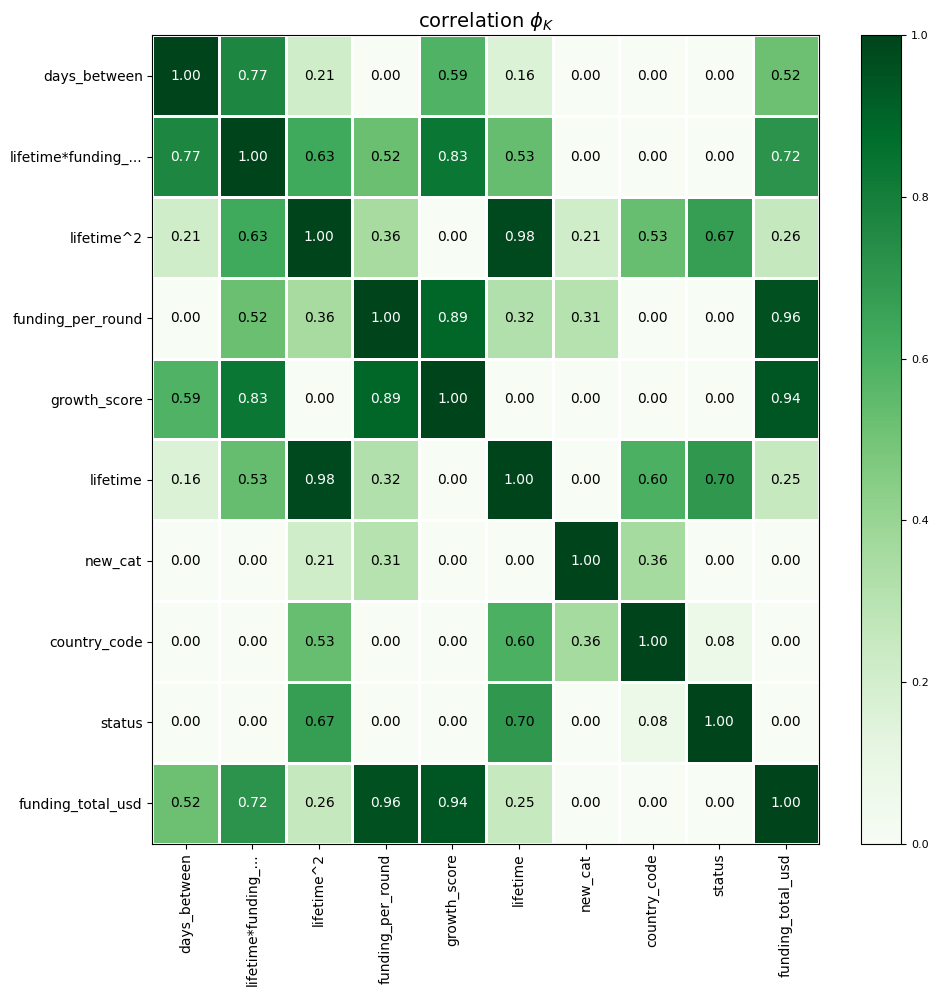

In [110]:
phik_overview = df.sample(100).phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Greens', 
                        title=r'correlation $\phi_K$', fontsize_factor=1, figsize=(10,10))
plt.tight_layout()

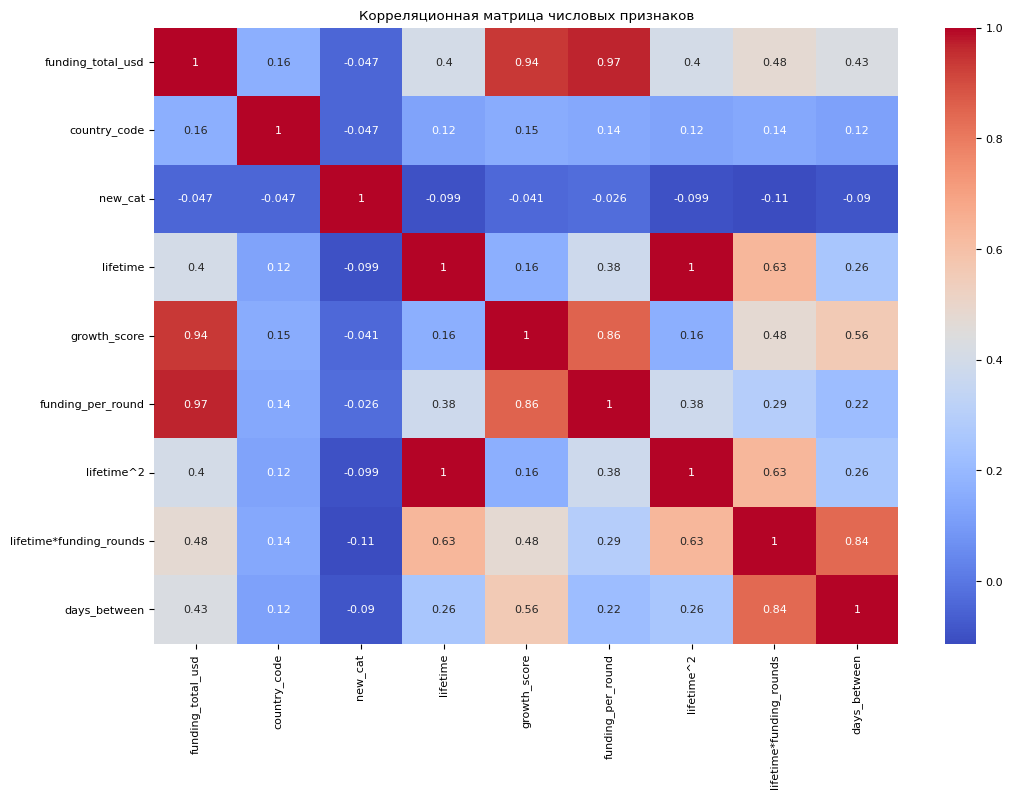

In [111]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(method='spearman', numeric_only = True), annot=True, 
            cmap='coolwarm', ax=ax)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

Что исключить мультиколлинеарность, применим variance_inflation_factor для нахождения таких признаков.

In [112]:
df_vif = df.copy()

In [113]:
def show_vif():
    interval_cols = df_vif.select_dtypes('number').columns.tolist()
    X = add_constant(df_vif[interval_cols])
    vif_data = pd.DataFrame()
    vif_data["Column"] = X.columns
     
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]
      
    print(vif_data)

In [114]:
show_vif()

                    Column           VIF
0                    const  11291.876239
1        funding_total_usd   4550.480309
2             country_code      1.043963
3                  new_cat      1.013113
4                 lifetime    312.385875
5             growth_score    499.967036
6        funding_per_round   2788.377440
7               lifetime^2    283.194491
8  lifetime*funding_rounds    135.416012
9             days_between     11.549511


Признаки содержат очень большое значение VIF, что говорит о наличии мультиколлинеарности. Уберем часть из них и посмотрим как изменится. 

In [115]:
df_vif = df_vif.drop(['funding_total_usd', 'growth_score', 'lifetime^2'], axis=1)

In [116]:
show_vif()

                    Column         VIF
0                    const  180.557869
1             country_code    1.042919
2                  new_cat    1.012744
3                 lifetime    1.345387
4        funding_per_round    1.178366
5  lifetime*funding_rounds    5.123387
6             days_between    4.611371


In [117]:
df = df.drop(['funding_total_usd', 'growth_score', 'lifetime^2'], axis=1)

<a id='report_feat'></a>
# Предварительный итог

На данном этапе была проведена работа с признаками. В первую очередь было проведено логарифмическое преобразование к числовым признаком для того чтобы получить нормальное распределение данных признаков. 
Затем было проведено полиномиальное преобразование в квадратичной степени к признакам `lifetime` и `funding_rounds` чтобы получить новые признаки и попробовать найти новые закономерности.
Также, с целью избавления от мультиколлинеарности, были удалены три признака `funding_total_usd`, `growth_score`, `lifetime^2`.

<a id='learn'></a>
# Обучение модели

In [118]:
def outlier_detector_(X, y):
    """
    Функция, которая с помощью алгоритма IsolationForest находит 1% выбросов,
    подсчитывает их и возвращает массив без этих значений
    """
    iso_forest = IsolationForest(contamination=0.01, random_state=RANDOM_STATE)
    outlier_index = iso_forest.fit_predict(X)
    
    # Подсчет количества выбросов
    outliers_count = (outlier_index == -1).sum()
    print(f"Количество выбросов: {outliers_count}")
    
    # Возвращение данных без выбросов
    return X[outlier_index == 1], y[outlier_index == 1]

In [119]:
X = df.drop('status', axis=1)

In [120]:
y = df['status']

In [121]:
X, y = outlier_detector_(X,y)

Количество выбросов: 517


Приведем целевой признак `status` к числовому.

In [122]:
le = LabelEncoder()

In [123]:
y = le.fit_transform(y)

In [124]:
num_subset = df.select_dtypes('number').columns.tolist()

In [125]:
cat_subset = []

Разобьем данные на train и test подвыборки.

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=RANDOM_STATE, 
                                                    shuffle=True, stratify=y)

In [127]:
num_transformer = ColumnTransformer([
    ('std_scaler', StandardScaler(), num_subset),
    ('robust_scaler', RobustScaler(), num_subset),
    ('minmax_scaler', MinMaxScaler(), num_subset)
])

In [128]:
cat_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_subset)
])

In [129]:
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_subset),
    ('cat', cat_transformer, cat_subset)
])

In [130]:
pipe_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('models', None) 
])

Зададим модели среди которых pipeline будет искать лучшую

In [131]:
param_grid = [
{
    'models': [CatBoostClassifier(random_seed=RANDOM_STATE, verbose=False)],
    'models__iterations': [300, 500],
    'models__depth': [4, 6],
    'models__learning_rate': [0.1, 0.2],
    'models__l2_leaf_reg': [1, 3, 5],
    'models__border_count': [32, 64, 128],
    'models__bagging_temperature': [0, 1, 10]
},
    {
    'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
    'models__max_depth': range(2, 10),
    'models__max_features': range(2, 5),
    'models__min_samples_split': range(2, 10),
    'models__min_samples_leaf': range(1, 5),
    'models__max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'models__min_impurity_decrease': [0.0, 0.1, 0.2, 0.3],
    'models__class_weight': [None, 'balanced'],
    'models__splitter': ['best', 'random']
},
{
    'models': [LogisticRegression(random_state=RANDOM_STATE)],
    'models__C': [0.01, 0.1, 1, 10, 100],
    'models__penalty': ['l2'],
    'models__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'models__max_iter': [100, 200, 300, 500]
}    
]

При подсчете f1_score будем использовать значение 'wieghted' чтобы компенсировать дисбаланс классов. 

In [132]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=500,
    scoring=make_scorer(f1_score, average='weighted'),
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [133]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               ColumnTransformer(transformers=[('std_scaler',
                                                                                                                StandardScaler(),
                                                                                                                ['country_code',
                                                                                                                 'new_cat',
                                                                                                                 'lifetime',
                                                                                                                 'funding_per_round',
                                                                                                                 'lifetime*funding_rounds',
                                                                                                                 'days_between']),
                                                                                                               ('robust_scaler',
                                                                                                                RobustScaler(),
                                                                                                                ['country_code',
                                                                                                                 'new_cat',
                                                                                                                 'lifetime',
                                                                                                                 'funding_per_...
                                         'models__min_samples_split': range(2, 10),
                                         'models__splitter': ['best',
                                                              'random']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': [0.01, 0.1, 1, 10, 100],
                                         'models__max_iter': [100, 200, 300,
                                                              500],
                                         'models__penalty': ['l2'],
                                         'models__solver': ['newton-cg',
                                                            'lbfgs',
                                                            'liblinear']}],
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [134]:
print("Лучший F1-скор: ", randomized_search.best_score_)

Лучший F1-скор:  0.9512451767404784


In [135]:
randomized_search.best_params_

{'models__learning_rate': 0.1,
 'models__l2_leaf_reg': 3,
 'models__iterations': 300,
 'models__depth': 6,
 'models__border_count': 128,
 'models__bagging_temperature': 10,
 'models': <catboost.core.CatBoostClassifier at 0x1eed942bc10>}

In [136]:
pd.DataFrame(randomized_search.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__splitter,param_models__min_samples_split,param_models__min_samples_leaf,param_models__min_impurity_decrease,param_models__max_leaf_nodes,param_models__max_features,...,param_models__bagging_temperature,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
102,6.703382,0.573487,0.052791,0.037788,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,"{'models__learning_rate': 0.1, 'models__l2_lea...",0.952323,0.953731,0.949328,0.951231,0.949613,0.951245,0.001654,1
168,0.082683,0.008304,0.017771,0.006074,best,5.0,3.0,0.0,20.0,3.0,...,NaN,"{'models__splitter': 'best', 'models__min_samp...",0.946185,0.949359,0.945131,0.945081,0.947370,0.946625,0.001602,2
86,0.076774,0.007940,0.018391,0.003320,best,9.0,1.0,0.0,20.0,4.0,...,NaN,"{'models__splitter': 'best', 'models__min_samp...",0.947215,0.948622,0.947747,0.944830,0.943552,0.946393,0.001897,3
364,0.063471,0.008033,0.015087,0.001921,best,8.0,1.0,0.0,30.0,4.0,...,NaN,"{'models__splitter': 'best', 'models__min_samp...",0.948452,0.949386,0.946351,0.943681,0.943355,0.946245,0.002436,4
418,0.062515,0.004305,0.015762,0.003025,best,4.0,2.0,0.0,50.0,3.0,...,NaN,"{'models__splitter': 'best', 'models__min_samp...",0.947342,0.948727,0.945232,0.942737,0.946962,0.946200,0.002059,5


Посмотрим вклад каждого признака 

In [137]:
coefficients = (randomized_search
                .best_estimator_
                .steps[-1][1]
                .feature_importances_)

                                        Feature  Importance
8                  num__robust_scaler__lifetime   18.577872
2                     num__std_scaler__lifetime   16.324045
14                 num__minmax_scaler__lifetime   16.227812
15        num__minmax_scaler__funding_per_round    5.332299
3            num__std_scaler__funding_per_round    5.023194
16  num__minmax_scaler__lifetime*funding_rounds    4.094316
13                  num__minmax_scaler__new_cat    3.827003
9         num__robust_scaler__funding_per_round    3.437662
7                   num__robust_scaler__new_cat    3.326671
17             num__minmax_scaler__days_between    3.106326
11             num__robust_scaler__days_between    2.937803
4      num__std_scaler__lifetime*funding_rounds    2.887764
12             num__minmax_scaler__country_code    2.704721
6              num__robust_scaler__country_code    2.664278
5                 num__std_scaler__days_between    2.602480
1                      num__std_scaler__

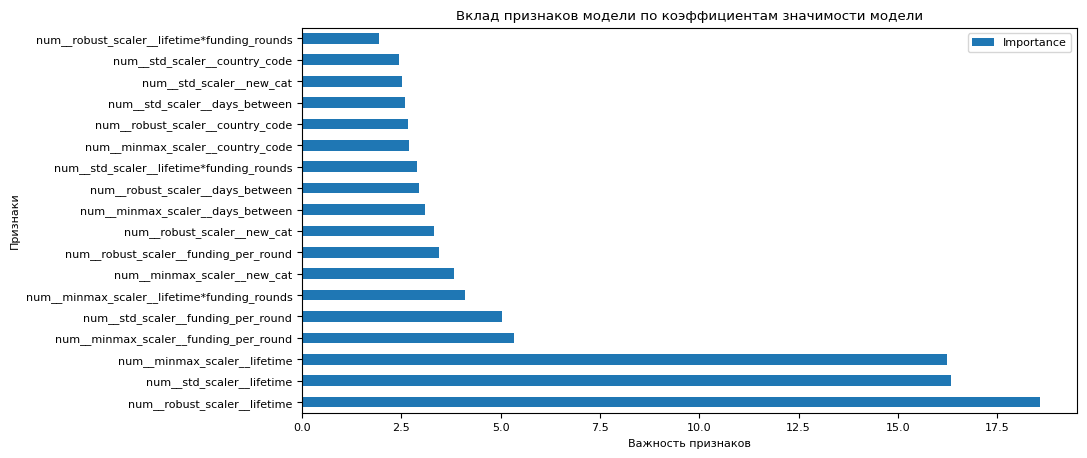

In [138]:
feature_imp = (pd.DataFrame({'Feature': randomized_search.best_estimator_
                             .named_steps['preprocessor']
                             .get_feature_names_out(), 
                             'Importance': np
                             .abs(coefficients)})
               .sort_values(by='Importance', ascending=False))
print(feature_imp)
feature_imp.plot(x='Feature', y='Importance', kind='barh', figsize=(10,5))
plt.title('Вклад признаков модели по коэффициентам значимости модели')
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.show()

График показывает что `lifetime` является ключевым признаком независимо от метода масштабирования.

In [139]:
y_pred = randomized_search.predict(X_test)

In [140]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.953629426726668


In [141]:
recall = recall_score(y_test, y_pred, average='weighted')  
print(f'Recall: {recall}')

Recall: 0.953629426726668


С учетом того что мы использовали recall с гиперпараметром 'weighted', мы получили совпадение значений accuracy и weighted recall это означает, что модель хорошо справляется с задачей и классы в данных сбалансированы.

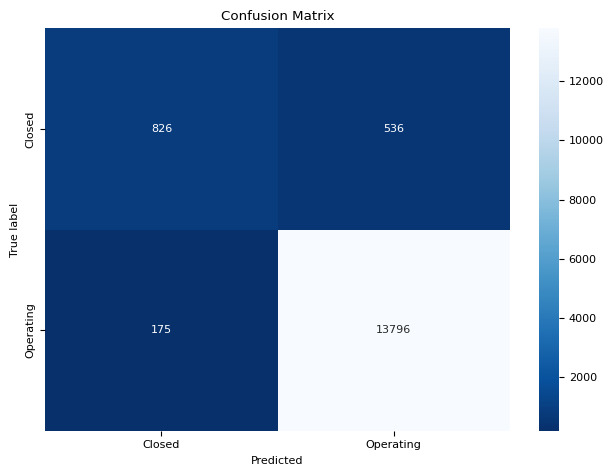

In [142]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Closed', 'Operating'])
ax.yaxis.set_ticklabels(['Closed', 'Operating'])
plt.tight_layout()
plt.show()

Ошибка первого рода: Стартап закрыт, а мы думаем, что он работает.

Ошибка второго рода: Стартап работает, а мы думаем, что он закрыт.

In [143]:
y_pred_proba = randomized_search.predict_proba(X_test)[:, 1]

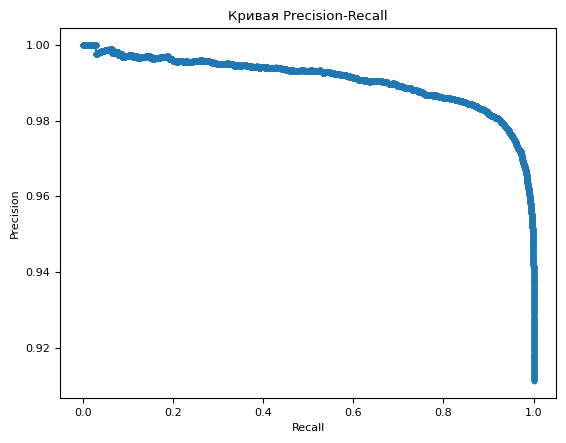

In [144]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Кривая Precision-Recall')
plt.show()

Посмотрим как меняется Confusion matrix при изменении пороговых значений.

In [145]:
new_threshold = .3

In [146]:
y_pred_prob = randomized_search.predict_proba(X_test)[:, 1]

In [147]:
y_pred_new = (y_pred_prob >= new_threshold).astype(int)

In [148]:
new_precision = precision_score(y_test, y_pred_new)
new_recall = recall_score(y_test, y_pred_new)
print(f'New Recall: {new_recall:.2f}')
print(f'New Precision: {new_precision:.2f}')

New Recall: 1.00
New Precision: 0.96


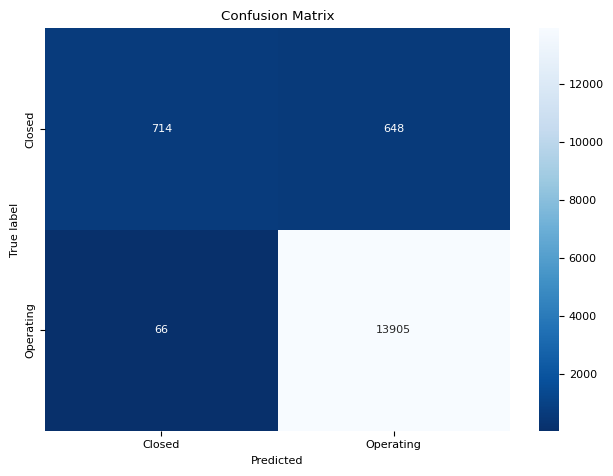

In [149]:
cm = confusion_matrix(y_test, y_pred_new)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Closed', 'Operating'])
ax.yaxis.set_ticklabels(['Closed', 'Operating'])
plt.tight_layout()
plt.show()

Посмотрим на DummyClassifier, который используется для создания базовой модели и предсказания классов по простым стратегиям. В данном случае был использован 'stratified' - предсказание классов с той же вероятностью, что и в тренировочных данных. 

In [150]:
dummy_clf = DummyClassifier(strategy='stratified')

In [151]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

In [152]:
y_test_dummy = dummy_clf.predict(X_test)

In [153]:
f1 = f1_score(y_test, y_test_dummy, average='weighted')
print(f'F1 score для DummyClassifier: {f1}')

F1 score для DummyClassifier: 0.8362783910700282


Посмотрим на важность признаков после обучения модели с использованием градиентного бустинга.

In [154]:
gbm = lgb.LGBMClassifier()
gbm.fit(X_train,y_train)
gbm.booster_.feature_importance()

[LightGBM] [Info] Number of positive: 32599, number of negative: 3178
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1107
[LightGBM] [Info] Number of data points in the train set: 35777, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911172 -> initscore=2.328030
[LightGBM] [Info] Start training from score 2.328030


array([344, 402, 944, 643, 326, 341])

In [155]:
fea_imp_ = pd.DataFrame({'cols':X_train.columns, 'fea_imp':gbm.feature_importances_})
fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False).head(20)

,cols,fea_imp
2,lifetime,944
3,funding_per_round,643
1,new_cat,402
0,country_code,344
5,days_between,341
4,lifetime*funding_rounds,326


Признак `lifetime` на данной модели также является наиболее важным.

Определим наиболее значимые признаки для модели с помощью метода рекурсивного исключения признаков.

In [156]:
rfe = RFE(estimator=gbm, n_features_to_select=6)
rfe = rfe.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 32599, number of negative: 3178
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1107
[LightGBM] [Info] Number of data points in the train set: 35777, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911172 -> initscore=2.328030
[LightGBM] [Info] Start training from score 2.328030


In [157]:
fea_rank_ = pd.DataFrame({'cols':X_train.columns, 'fea_rank':rfe.ranking_})
fea_rank_.loc[fea_rank_.fea_rank > 0].sort_values(by=['fea_rank'], ascending = True).head(20)

,cols,fea_rank
0,country_code,1
1,new_cat,1
2,lifetime,1
3,funding_per_round,1
4,lifetime*funding_rounds,1
5,days_between,1


Ранжирование признаков у всех признаков 1, это говорит что все признаки важны.

Построим SHAP графики

In [158]:
X_train_shap = (pipe_final
                .named_steps['preprocessor']
                .fit_transform(X_train))

In [159]:
explainer = (shap
             .TreeExplainer(randomized_search
                              .best_estimator_
                              .named_steps['models'], 
                              X_train_shap, 
                              feature_names=pipe_final
                              .named_steps['preprocessor']
                              .get_feature_names_out()))

In [160]:
X_test_shap = pipe_final.named_steps['preprocessor'].transform(X_test)

In [161]:
shap_values = explainer(X_test_shap, check_additivity=False)

100%|===================| 15301/15333 [01:42<00:00]        

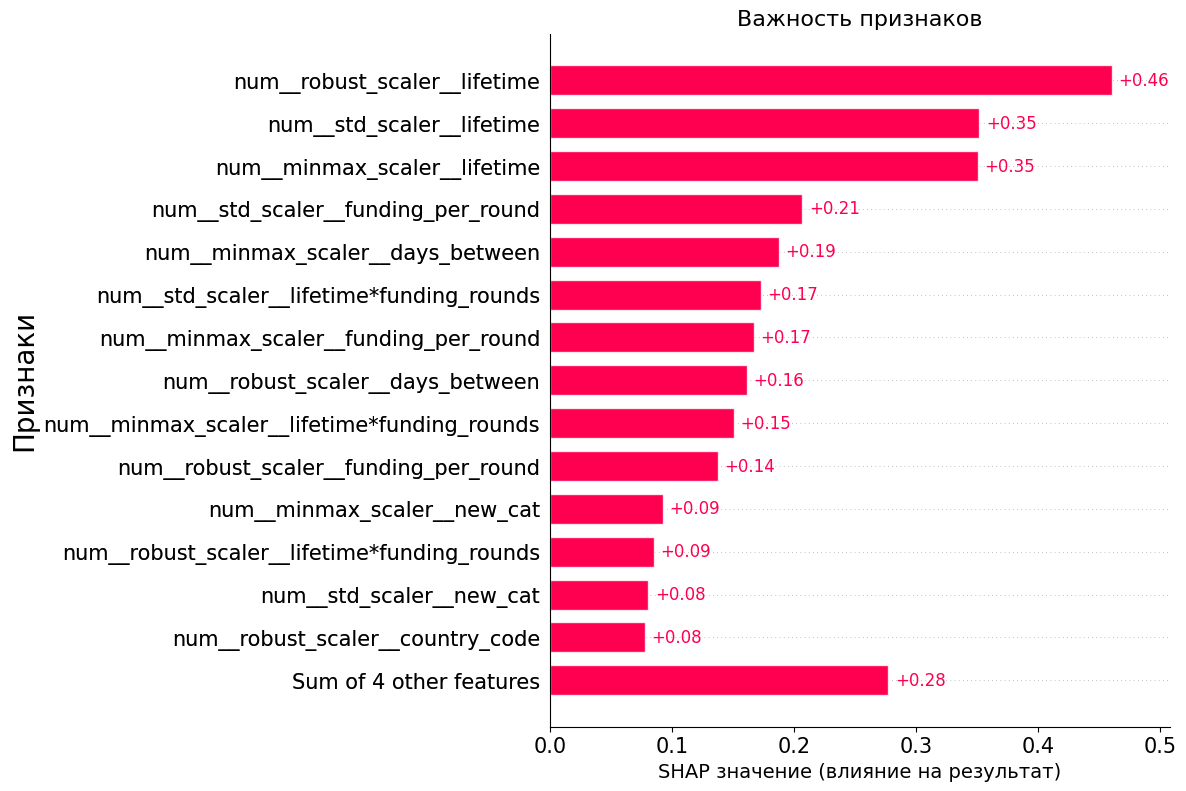

In [162]:
plt.title('График общей значимости признаков')
shap.plots.bar(shap_values, max_display = 15, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP значение (влияние на результат)", fontsize=14)
ax.set_title('Важность признаков', fontsize=16)

# Get colorbar
cb_ax = fig.axes[0] 

# Modifying color bar parameters
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel("Признаки", fontsize=20)

plt.show()

График показывает что lifetime является ключевым признаком независимо от метода масштабирования.

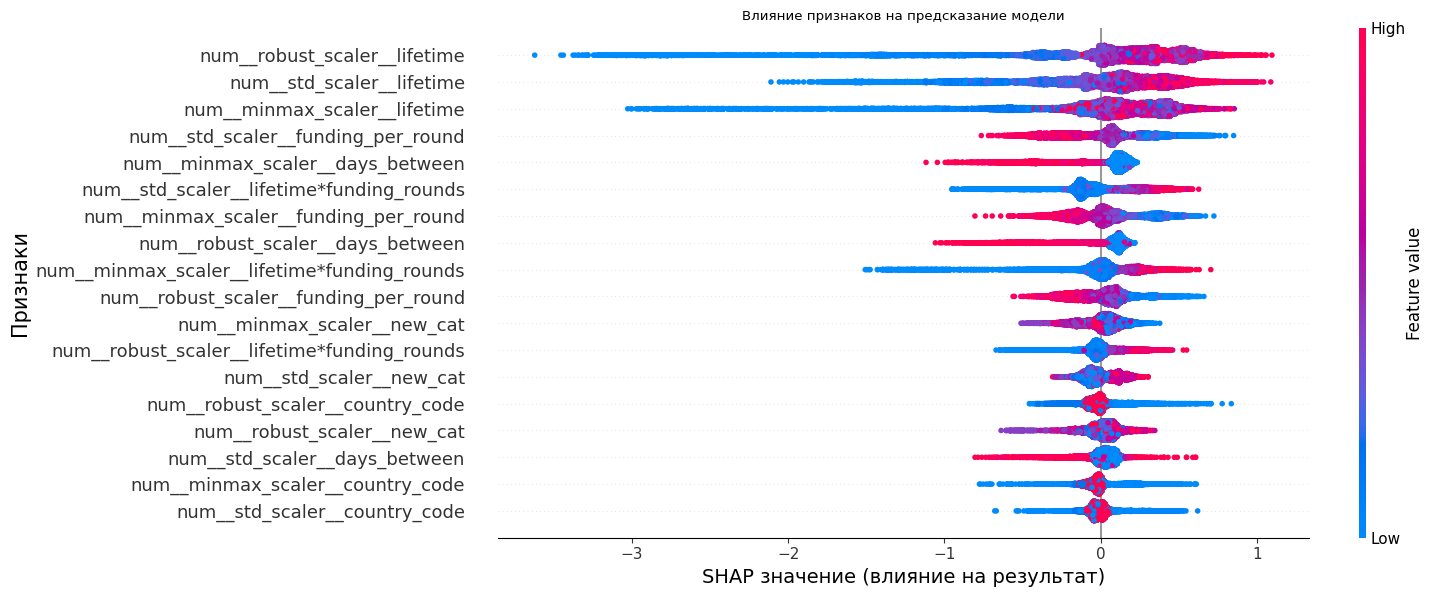

In [163]:
plt.title('Влияние признаков на предсказание модели')
(shap.summary_plot(shap_values,
                  X_test_shap,
                  show=False,
                  plot_size =[15,6], 
                  feature_names = pipe_final
                  .named_steps['preprocessor']
                  .get_feature_names_out()))
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel("SHAP значение (влияние на результат)", fontsize=14)
cb_ax = fig.axes[0] 
cb_ax.set_ylabel("Признаки", fontsize=15)
plt.show()

Чем больше значение признака `lifetime` тем больше модель стремится к прогнозированию статуса 'operating'. 

<a id='report_learn'></a>
# Предварительный вывод

На данном этапе была обучена модель для дальнейшего прогноза статуса стартапа. Перед этим был удален 1% выбросов из датафрейма (что составляло 517 строк). 
Для обучения модели были использованы CatBoostClassifier, DecisionTreeClassifier, LogisticRegression с различными гиперпараметрами. 

При использовании *RandomizedSearchCV* и расчета f1_score был использован гиперпараметр 'weighted' чтобы компенсировать дисбаланс классов.
**Лучший F1-скор**:  0.9512451767404784 получился с помощью модели **CatBoostClassifier**. **CatBoostClassifier** это алгоритм градиентного бустинга на решающих деревьях. Алгоритм автоматически обрабатывает категориальные признаки, преобразуя их в числовые значения. Затем строит ансамбль решающих деревьв, где каждое последующее дерево корректирует ошибки предыдущих деревьев. **CatBoostClassifier** был использован со следующими параметрами:

`'models__learning_rate': 0.1` - Скорость обучения. Этот гиперпараметр определяет, насколько сильно модель обновляет свои параметры на каждой итерации. Значение 0.1 делает обучение более стабильным, но медленным.

`'models__l2_leaf_reg': 3` - Коэффициент регуляризации L2. Этот гиперпараметр контролирует степень регуляризации, которая помогает предотвратить переобучение модели. Более высокие значения приводят к более сильной регуляризации.

`'models__iterations': 300` - Количество итераций. Этот гиперпараметр определяет количество деревьев, которые будут построены в процессе обучения. Большее количество итераций может улучшить точность модели, но также увеличивает время обучения.

`'models__depth': 6` - Глубина деревьев. Этот гиперпараметр определяет максимальную глубину деревьев. Более глубокие деревья могут захватывать более сложные зависимости в данных, но также могут привести к переобучению.

`'models__border_count': 128` - Количество границ для разбиения числовых признаков. Этот гиперпараметр определяет, на сколько частей будут разбиты числовые признаки. Большее количество границ может улучшить точность модели, но также увеличивает сложность и время обучения.

`'models__bagging_temperature': 10` - Температура для метода bagging. Этот гиперпараметр контролирует степень случайности при выборе подвыборок для построения деревьев. Более высокие значения увеличивают разнообразие деревьев, что может улучшить обобщающую способность модели.

В отличие от **DecisionTreeClassifier** и **LogisticRegression**, **CatBoostClassifier** автоматически обрабатывает категориальные признаки и благодаря использованию метода *Ordered Boosting* менее подвержен переобучению.

**Основные компоненты CatBoost**:

- ***Градиентный бустинг***: CatBoost строит ансамбль решающих деревьев, где каждое последующее дерево корректирует ошибки предыдущих деревьев. Это достигается путем минимизации функции потерь. Основная идея градиентного бустинга заключается в минимизации функции потерь 
𝐿(𝑦,𝐹(𝑥)), где 𝑦 — истинные значения, а 𝐹(𝑥) — предсказанные значения. На каждом шаге 𝑚 добавляется новое дерево ℎ𝑚(𝑥), чтобы минимизировать функцию потерь:
                                                            **<center>Fm(x)=Fm−1(x)+γhm(x)</center>** где 𝛾 — коэффициент обучения.

 - ***Обработка категориальных признаков***: CatBoost автоматически обрабатывает категориальные признаки, преобразуя их в числовые значения с помощью метода "счётчиков" (count-based statistics). Для каждого категориального признака 𝑐 и значения 𝑣 вычисляется среднее значение целевой переменной для всех объектов с этим значением признака.

- ***Ordered Boosting***: На каждом шаге веса обновляются с учетом градиента функции потерь. Этот метод уменьшает вероятность переобучения, особенно на малых выборках, путем использования упорядоченных статистик.

Графики **оценки важности и вклада признаков** показали что признак `lifetime` является ключевым, независимо от метода масштабирования.

**Accuracy**: 0.953629426726668

**Recall**: 0.953629426726668

С учетом того что мы использовали *recall* с гиперпараметром 'weighted', мы получили совпадение значений *accuracy* и *recall* это означает, что модель хорошо справляется с задачей и классы в данных сбалансированы.

По *confusion matrix* можно сказать следующее: модель 536 ошибочно предсказывает что стартап продолжает работать, и 175 раз что закрыт.


<a id='predict'></a>
# Предсказание статуса 

Применим полученную модель для прогнозирования статуса стартапа. Для этого сначала загрузим второй датафрейм и повторим работу с признаками.

In [164]:
df_test = pd.read_csv('./kaggle_startups_test_28062024.csv')

Заполним строковые признаки значением 'Other'

In [165]:
columns_to_fill = ['name', 'category_list', 'country_code', 
                   'state_code', 'region', 'city']

In [166]:
df_test[columns_to_fill] = df_test[columns_to_fill].fillna('Other')

Создадим новый признак `new_cat` как самая популярная категория из `category_list`

In [167]:
for categories in df_test['category_list'].str.split('|'):
    all_categories.update(categories)

In [168]:
df_test['new_cat'] = df_test['category_list'].apply(most_frequent_category)

Заполним медианной пустые значения признака `funding_total_usd`

In [169]:
df_test['funding_total_usd'] = (df_test.groupby(['city', 'new_cat'])['funding_total_usd']
                                .transform(lambda x: fill_with_median(x, medians)))

Добавим новые признаки исспользуемые при обучении

In [170]:
df_test['growth_score'] = ((df_test['funding_total_usd'] * df_test['funding_rounds']) 
                           / df_test['lifetime'])

In [171]:
df_test['funding_per_round'] = df_test['funding_total_usd'] / df_test['funding_rounds']

Применим логарифм к числовым признакам

In [172]:
df_test["funding_total_usd"] = np.log1p(df_test["funding_total_usd"])

In [173]:
df_test["lifetime"] = np.log1p(df_test["lifetime"])

In [174]:
df_test['funding_per_round'] = np.log1p(df_test["funding_per_round"])

In [175]:
df_test['growth_score'] = np.log1p(df_test["growth_score"])

In [176]:
df_test["funding_rounds"] = np.log1p(df_test["funding_rounds"])

Создадим полиномиальные признаки

In [177]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

In [178]:
poly_columns = poly_features.fit_transform(df_test[['lifetime', 'funding_rounds']])

In [179]:
df_poly = pd.DataFrame(poly_columns, 
                       columns=['lifetime', 'funding_rounds', 'lifetime^2', 
                                'lifetime*funding_rounds', 'funding_rounds^2'],
                       index=df_test.index)

In [180]:
df_poly = df_poly.drop(['lifetime', 'funding_rounds'], axis=1)

In [181]:
df_test = pd.concat([df_test, df_poly], axis=1)

In [182]:
df_test['first_funding_at'] = pd.to_datetime(df_test['first_funding_at'])
df_test['last_funding_at'] = pd.to_datetime(df_test['last_funding_at'])
df_test['days_between'] = (df_test['last_funding_at'] - df_test['first_funding_at']).dt.days

In [183]:
df_test["days_between"] = np.log1p(df_test["days_between"])

Переведем признак `country_code` из категориальных в числовые

In [184]:
df_test['country_code'] = df_test['country_code'].map(frequency_encoding)

Сгруппируем позиции по признаку `new_cat`

In [185]:
tfidf_matrix_test = vectorizer.transform(df_test['new_cat'])

In [186]:
test_labels = kmeans.predict(tfidf_matrix_test)

In [187]:
clustered_test_df = pd.DataFrame({'new_cat': df_test['new_cat'], 'cluster': test_labels})

In [188]:
df_test['new_cat'] = clustered_test_df['cluster']

In [189]:
df_test = df_test.drop(['funding_total_usd', 'growth_score', 'lifetime^2'], axis=1)

Удалим признаки которые не будем использовать при прогнозе

In [190]:
df_test = df_test.drop(['name','category_list', 'state_code', 'region','city',
                        'first_funding_at', 'last_funding_at', 'funding_rounds', 
                        'funding_rounds^2'], axis=1)

Приведем столбцы к одинаковому расположению признаков для корректного прогнозирования. 

In [191]:
df_test = df_test.reindex(columns=X_train.columns.to_list())

In [192]:
df_test.head()

,country_code,new_cat,lifetime,funding_per_round,lifetime*funding_rounds,days_between
0,0.000019,5,8.161090,14.851964,5.656836,0.000000
1,0.575261,11,7.907652,14.508658,5.481166,0.000000
2,0.000446,14,7.167038,12.274336,7.873796,4.844187
3,0.575261,0,8.465689,15.975956,13.625001,7.568379
4,0.029829,0,8.733916,15.326233,6.053889,0.000000


In [193]:
X_train.head()

,country_code,new_cat,lifetime,funding_per_round,lifetime*funding_rounds,days_between
34739,0.575261,10,8.541105,15.137267,13.746378,6.748760
49290,0.089449,12,7.520776,16.118096,5.213005,0.000000
33014,0.575261,4,8.203578,12.918817,9.012551,6.122493
32801,0.575261,3,7.994970,16.300417,5.541691,0.000000
24100,0.575261,0,7.695303,13.997833,5.333978,0.000000


Сделаем предсказание и посмотрим на получившийся результат

In [194]:
y_new_pred = randomized_search.best_estimator_.predict(df_test)

In [195]:
df_test['pred'] = y_new_pred

In [196]:
df_test['pred'] = df_test['pred'].apply(lambda x: 'operating' if x == 1 else 'closed')

In [197]:
df_test['pred'].value_counts()

pred
operating    12188
closed         937
Name: count, dtype: int64

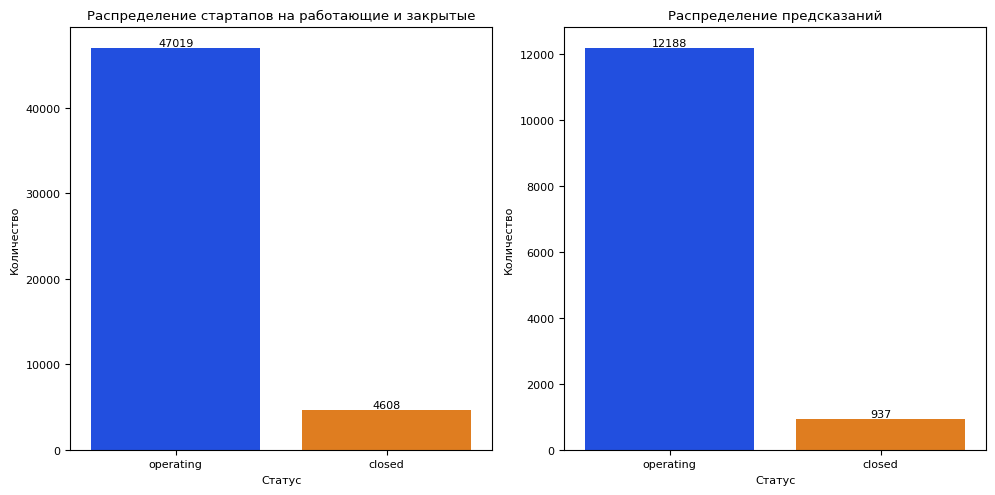

In [198]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

ax1 = sns.countplot(ax=axes[0], x=df['status'], palette='bright', legend=False)
for container in ax1.containers:
    ax1.bar_label(container)
axes[0].set_title('Распределение стартапов на работающие и закрытые')
axes[0].set_xlabel('Статус')
axes[0].set_ylabel('Количество')

ax2 = sns.countplot(ax=axes[1], x=df_test['pred'], palette='bright', legend=False)
for container in ax2.containers:
    ax2.bar_label(container)
axes[1].set_title('Распределение предсказаний')
axes[1].set_xlabel('Статус')
axes[1].set_ylabel('Количество')

plt.tight_layout()
plt.show()

In [199]:
(pd.DataFrame({'Текущие показатели': df['status'].value_counts(),
              'Предсказанные показатели1': df_test['pred'].value_counts(),
              'Current percent': df['status'].value_counts()[1]/df['status'].value_counts()[0]*100, 
               'Predict percent': df_test['pred'].value_counts()[1]/df_test['pred'].value_counts()[0]*100}))

,Текущие показатели,Предсказанные показатели1,Current percent,Predict percent
operating,47019,12188,9.800293,7.68789
closed,4608,937,9.800293,7.68789


Предсказание статуса стартапа показывает что прогнозируется снижение количества закрытых стартапов приблизительно на 2%

Сохраним получившиеся данные в отдельный датафрейм

In [200]:
final = pd.read_csv('kaggle_startups_test_28062024.csv')


In [201]:
final = final['name']

In [202]:
super_final = pd.concat([final, df_test['pred']], axis=1)

In [203]:
super_final = super_final.rename({'pred': 'status'}, axis=1)

In [204]:
super_final.to_csv('test.csv', index=False)

<a id='total_review'></a>
# Общий вывод

**Целью** данной работы было разработать модель для предсказания успешности стартапа (закроется или нет).

В качестве ***первого этапа*** мы загрузили данные и получили общую информацию по ним. Датафрейм содержит 52516 записей и 13 признаков, один из которых целевой `status`. Датафрейм содержал как строковые так и числовые типы данных. Отметили большое количество пропущенных значений в 9 признаках. В описательной статистике видно что числовые признаки содержат очень большой разброс данных, а строковые содержат много уникальных данных.

На этапе ***предобработки данных*** были обработаны все пропуски в 9 признаках. Также были выявлены и удалены явные дубликаты. Обработанный датафрейм содержит 51627 записей. Корреляционная матрица phik показала сильную корреляцию между многими признаками.

Для проведения ***исследовательского анализа*** были созданы дополнительные признаки:
- `lifetime` - продолжительность жизни стартапа
- `growth_score` - насколько быстро растет стартап
- `funding_per_round` - сколько, в среднем, за один инвестиционный раунд было привлечено средств
- `found_year` - год основания стартапа, 
- `found_month` - месяц основания стартапа  
- `len_cat` - число категорий с которыми работает стартап. 

Диаграмма размаха показала что все числовые признаки содержат очень большой разброс данных. Особенно выделялся один выброс в признаке `funding_total_usd`, который мы удалили для более точного обучения модели.
Подавляющее большинство стартапов (почти 70%) представлено в *USA*, а самая популярная категория идет *software (25%)*, затем *obile (14%)* и *biotechnology (13%)*.

Больше всего стартапов создано в категории *softwate*, там же наблюдается и самое большое количество закрытых стартапов, но в % соотношении оно самое минимальное, за счет количества открытых. Худшая ситуация по количеству открытых/закрытых наблюдается в категории *Other*.
В графике по странам, в *Other* так же худшая ситуация, а с положительной точки зрения *USA* лидирует с большим отрывом (27415 открытых стартапов).
Большинство стартапов провели 1 инвестиционный раунд, однако есть и стартапы которые провели более 15 раундов. Больше всех инвестиционных раундов провела *USA* - 57 474 раундов.

Целевой признак `status` имеет сильный дисбаланс - 47019 открытых против 4608 закрытых.

Несмотря на то что большинство стартапов создаются в категории *software*, больше всех денег принесла категория *biotechnology*. По странам больше всех денег принесли стартапы из *USA* - 504 млрд долларов. 

По соотношению % по соотношению открытых/закрытых стартапов, лидирует *IND* с показателем 95.8%. *USA* лидируя по количественному признаку, в % соотношении на 2 месте с показателем 92.3%.
Лучший показатель в % соотношении среди категорий находится у *biotechnology* с результатом 92.4%.

Диаграммы рассеяния показала точечные выбросы на каждом графике, наибольшая корреляция наблюдается между признаками `funding_total_usd` и `funding_per_round`, что логично, так как чем больше инвестиционных раундов проводит стартап, тем больше денег это может привести. Также стоит отметить что в основном закрытие происходит в первые 4-5 лет стартапа.

Категория *software* наиболее популярная в 11 странах из топ15.

Количество стартапов росло с каждым годом начиная с 2002 года, пик основания стартапов пришелся на 2013 год, после этого наблюдается спад. Количество стартапов в 2014 году меньше уже почти на 2042 по сравнению с 2013 годом, а в 2015 уже на 5566 меньше чем в 2013 году. Данные по 2016-2017 годам в распределение вообще не попали из-за малого количества. 
Распределение по месяцам выглядит еще интереснее, 46% стартапов создаются в 1 месяц года.

С целью поиска мультиколлинеарности и нормализации данных, на этапе ***работы с признаками*** была проведена обработка существующих признаков. В первую очередь было проведено логарифмическое преобразование к числовым признаком для того чтобы получить нормальное распределение данных признаков. 
Затем было проведено полиномиальное преобразование в квадратичной степени к признакам `lifetime` и `funding_rounds` чтобы получить новые признаки и попробовать найти новые закономерности.
Также, с целью избавления от мультиколлинеарности, были удалены три признака `funding_total_usd`, `growth_score`, `lifetime^2`.

Следующим этапом было ***обучение модели***. Перед этим был удален 1% выбросов из датафрейма (что составляло 517 строк). 
Для обучения модели были использованы *CatBoostClassifier*, *DecisionTreeClassifier*, *LogisticRegression* с различными гиперпараметрами. 

При использовании *RandomizedSearchCV* и расчета *f1_score* был использован гиперпараметр *weighted* чтобы компенсировать дисбаланс классов.
**Лучший F1-скор**:  0.9512451767404784 получился с помощью модели **CatBoostClassifier**. **CatBoostClassifier** это алгоритм градиентного бустинга на решающих деревьях. Алгоритм автоматически обрабатывает категориальные признаки, преобразуя их в числовые значения. Затем строит ансамбль решающих деревьв, где каждое последующее дерево корректирует ошибки предыдущих деревьев. **CatBoostClassifier** был использован со следующими параметрами:

- `'models__learning_rate': 0.1` - Скорость обучения. Этот гиперпараметр определяет, насколько сильно модель обновляет свои параметры на каждой итерации. Значение 0.1 делает обучение более стабильным, но медленным.
- `'models__l2_leaf_reg': 3` - Коэффициент регуляризации L2. Этот гиперпараметр контролирует степень регуляризации, которая помогает предотвратить переобучение модели. Более высокие значения приводят к более сильной регуляризации.
- `'models__iterations': 300` - Количество итераций. Этот гиперпараметр определяет количество деревьев, которые будут построены в процессе обучения. Большее количество итераций может улучшить точность модели, но также увеличивает время обучения.
- `'models__depth': 6` - Глубина деревьев. Этот гиперпараметр определяет максимальную глубину деревьев. Более глубокие деревья могут захватывать более сложные зависимости в данных, но также могут привести к переобучению.
- `'models__border_count': 128` - Количество границ для разбиения числовых признаков. Этот гиперпараметр определяет, на сколько частей будут разбиты числовые признаки. Большее количество границ может улучшить точность модели, но также увеличивает сложность и время обучения.
- `'models__bagging_temperature': 10` - Температура для метода bagging. Этот гиперпараметр контролирует степень случайности при выборе подвыборок для построения деревьев. Более высокие значения увеличивают разнообразие деревьев, что может улучшить обобщающую способность модели.

В отличие от **DecisionTreeClassifier** и **LogisticRegression**, **CatBoostClassifier** автоматически обрабатывает категориальные признаки и благодаря использованию метода *Ordered Boosting* менее подвержен переобучению.

**Основные компоненты CatBoost**:

- ***Градиентный бустинг***: CatBoost строит ансамбль решающих деревьев, где каждое последующее дерево корректирует ошибки предыдущих деревьев. Это достигается путем минимизации функции потерь. Основная идея градиентного бустинга заключается в минимизации функции потерь 
𝐿(𝑦,𝐹(𝑥)), где 𝑦 — истинные значения, а 𝐹(𝑥) — предсказанные значения. На каждом шаге 𝑚 добавляется новое дерево ℎ𝑚(𝑥), чтобы минимизировать функцию потерь:
                                                            **<center>Fm(x)=Fm−1(x)+γhm(x)</center>** где 𝛾 — коэффициент обучения.

 - ***Обработка категориальных признаков***: CatBoost автоматически обрабатывает категориальные признаки, преобразуя их в числовые значения с помощью метода "счётчиков" (count-based statistics). Для каждого категориального признака 𝑐 и значения 𝑣 вычисляется среднее значение целевой переменной для всех объектов с этим значением признака.

- ***Ordered Boosting***: На каждом шаге веса обновляются с учетом градиента функции потерь. Этот метод уменьшает вероятность переобучения, особенно на малых выборках, путем использования упорядоченных статистик.

Графики ***оценки важности и вклада признаков*** показали что признак `lifetime` является ключевым, независимо от метода масштабирования.

**Accuracy**: 0.953629426726668

**Recall**: 0.953629426726668

С учетом того что мы использовали *recall* с гиперпараметром 'weighted', мы получили совпадение значений *accuracy* и *recall* это означает, что модель хорошо справляется с задачей и классы в данных сбалансированы.

*Confusion matrix* показала: модель 536 ошибочно предсказывает что стартап продолжает работать, и 175 раз ошибочно что закрыт.

На последнем ***этапе предсказания*** мы получили предсказание для целевого таргета `status`. Значения которые получились, показывают что наблюдается небольшая положительная динамика по открытым стартапам (число закрытых составляло 9.8% от числа открытых, а на тестовой выборке прогнозируется 7.7%). 

***В качестве рекомендаций***: наиболее перспективным видится открытие стартапа в *USA* (как страна, в которой больше всего привлекается средств по стартапам) или в *IND* (как страна, в которой наибольший % по соотношению открытых к общему числу). Предпочтительными категориями видятся *Software*, *Biotechnology* и *E-Commerce*, это категории которые привлекают больше всех средств и в которых наибольший % по соотношению открытых к общему числу. 
Важным моментом для стартапа является пережить приблизительно первые 4-5 лет, так как именно в это время чаще всего происходит закрытие стартапа. Для этого важно проводить больше инвестиционных раундов, при этом количество категорий, в которых представлен стартап значения не имеет.
